# TorchSDE + Neuromancer: Moving from Neural ODEs to Neural SDEs and Motivating the Latent SDE Architecture

This notebook goes over how to utilize torchsde's functionality within Neuromancer framework. This notebook is based off: https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py. In this example, we generate data according to a 3-dimensional stochastic Lorenz attractor. We then perform a "system identification" on this data -- seek to model a stochastic differential equation on this data. Upon performant training, this LatentSDE will then be able to reproduce samples that exhibit the same behavior as the provided Lorenz system. We train and utilize the Lightning framework to support custom functionality within the training loop.




### From Neural ODEs to Neural SDEs

#### 1. Neural ODEs

The general form of an ordinary differential equation (ODE) is:

$$ \frac{{dx}}{{dt}} = f(t, x) $$

Neural ODEs parameterize the evolution of the system, in continuous-time, in terms of a neural network: $ \frac{{dx}}{{dt}}  = f_{\theta}(x_k)$ where $\theta$ are network weights


Next we need to solve the continuous-time NODE model with suitable ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).  

$$ x_{k+1} = \text{ODESolve}(f_{\theta}(x_k)) $$




For training we need to obtain accurate reverse-mode gradients of the integrated NODE system. This can be done in two ways, either by unrolling the operations of the ODE solver and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm, or via [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method). Assuming we have a suitable ODE solver (integrator) then we can train $f_{\theta}(x_k)$ using our standard reference tracking loss (MSE) between predicted and ground-truth trajectory as they unroll.


Neuromancer provides a set of ODE solvers implemented in [integrators.py](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/dynamics/integrators.py).
For adjoint method we provide the interface to the [open-source implementation](https://github.com/rtqichen/torchdiffeq) via DiffEqIntegrator class.

#### 2. Latent ODEs

We can reformulate the above reference-tracking method for training Neural ODEs via a generative / variational inference approach. That is 
$$ z_{t_0} ∼ p(z_{t_0}) $$

$$ z_{t_1}, z_{t_2}, ..., z_{t_N} = ODESolve(z_{t_0}, f, θ_f, t_0, ..., t_N) $$

where each $$ x_{t_i} ∼ p(x|z_{t_i}, θ_x) $$

In this way the evolution of the latent states follow an ordinary differential equation and we observe observations emitted from the latent system dynamics. Since we never actually observe the "point estimates" of $z$ we have to integrate over $z$ to learn p(x), which can be done by treating this as a standard variational autoencoder network and training thusly.

#### 3. Neural ODEs with Added Stochasticicity

Stochastic differential equations are an extension of ordinary differential equations in that they are ODEs with instantaneous noise dynamics added to their determinisitic system dynamics. We denote the former as the diffusion process; the latter the drift process. They are often used to model phenomena governed by many small and unobserved interactions in chemistry and microbiology such as molecular motion in liquid; allele frequencies in genetics. They are also known to model price fluctations in financial markets for short-medium time horizons. 

The general form of a stochastic differential equation is, in differential form:

$$ dx = f(t, x) \, dt + g(t, x) \, dW $$

Where $W$ denotes a Weiner process (e.g. Brownian motion). We can see that if $g()$ is zero then the SDE simplifies to an ODE. Thus for training SDEs, we need an equivalent BPTT or adjoint state method to compute tractable and scalable gradients. Li, et al recently developed such an analogous backpropagation algorithm in https://arxiv.org/pdf/2001.01328. In our codebase we leverage such SDE solvers via the torchSDE library (https://github.com/google-research/torchsde/tree/master/torchsde). For reference, the main reason we can use numerical solvers for this stochastic calculus case is that the above differential equation's dynamics can be interepreted as: 

$$ X_{t+\Delta t} \approx \text{ODESolve}\left(X_t, f(\cdot) + g(\cdot) \frac{\Delta W}{\Delta t}, [t, t+\Delta t]\right) $$

(See the Euler-Murayama method)


 Given that these solvers exist, we now move on to the question of **training these non-deterministic dynamics. What loss do we optimize**? 

Fitting an SDE in the same vein as an ODE (e.g. via maximal likelihood -- our reference tracking (MSE) loss since we assume Gaussian distribution) **will not work**: it will overfit and send the diffusion term to zero. Thus the inclusion of the diffusion term into our differential equation is a roadblock formulating the SDE in a rollout-based manner as we do with Neural ODEs. Devising loss functions to support rollout and physical constraints on the system is an open research question. 

#### 4. Latent SDEs

It is natural to view training a Neural SDE from a probabilistic perspective: given training samples from a stochastic process, we wish to devise neural network(s) parameterizing the drift and diffusion terms (and perhaps other terms as well as shown below) that has the ability generate new data samples governed by the (learned) stochastic process. Thus we can employ the variational autoencoder approach similar to latent ODEs, but now the evolution of the latent states is modeled by an SDE and not an ODE. Other approaches exist as well, such as treating the SDE as Generative Adversarial Network (GAN). We only show the variational autoencoder form here.







______

## 0. Imports


In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.distributions import Normal

import tqdm
import torchsde

from neuromancer.psl import plot
from neuromancer import psl
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer, LitTrainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

from typing import Sequence

torch.manual_seed(0)


## 1. Neural ODE

To motivate this walkthrough, we first construct a Neural ODE to solve a (deterministic) Lotka-Volterra System

<Figure size 500x100 with 0 Axes>

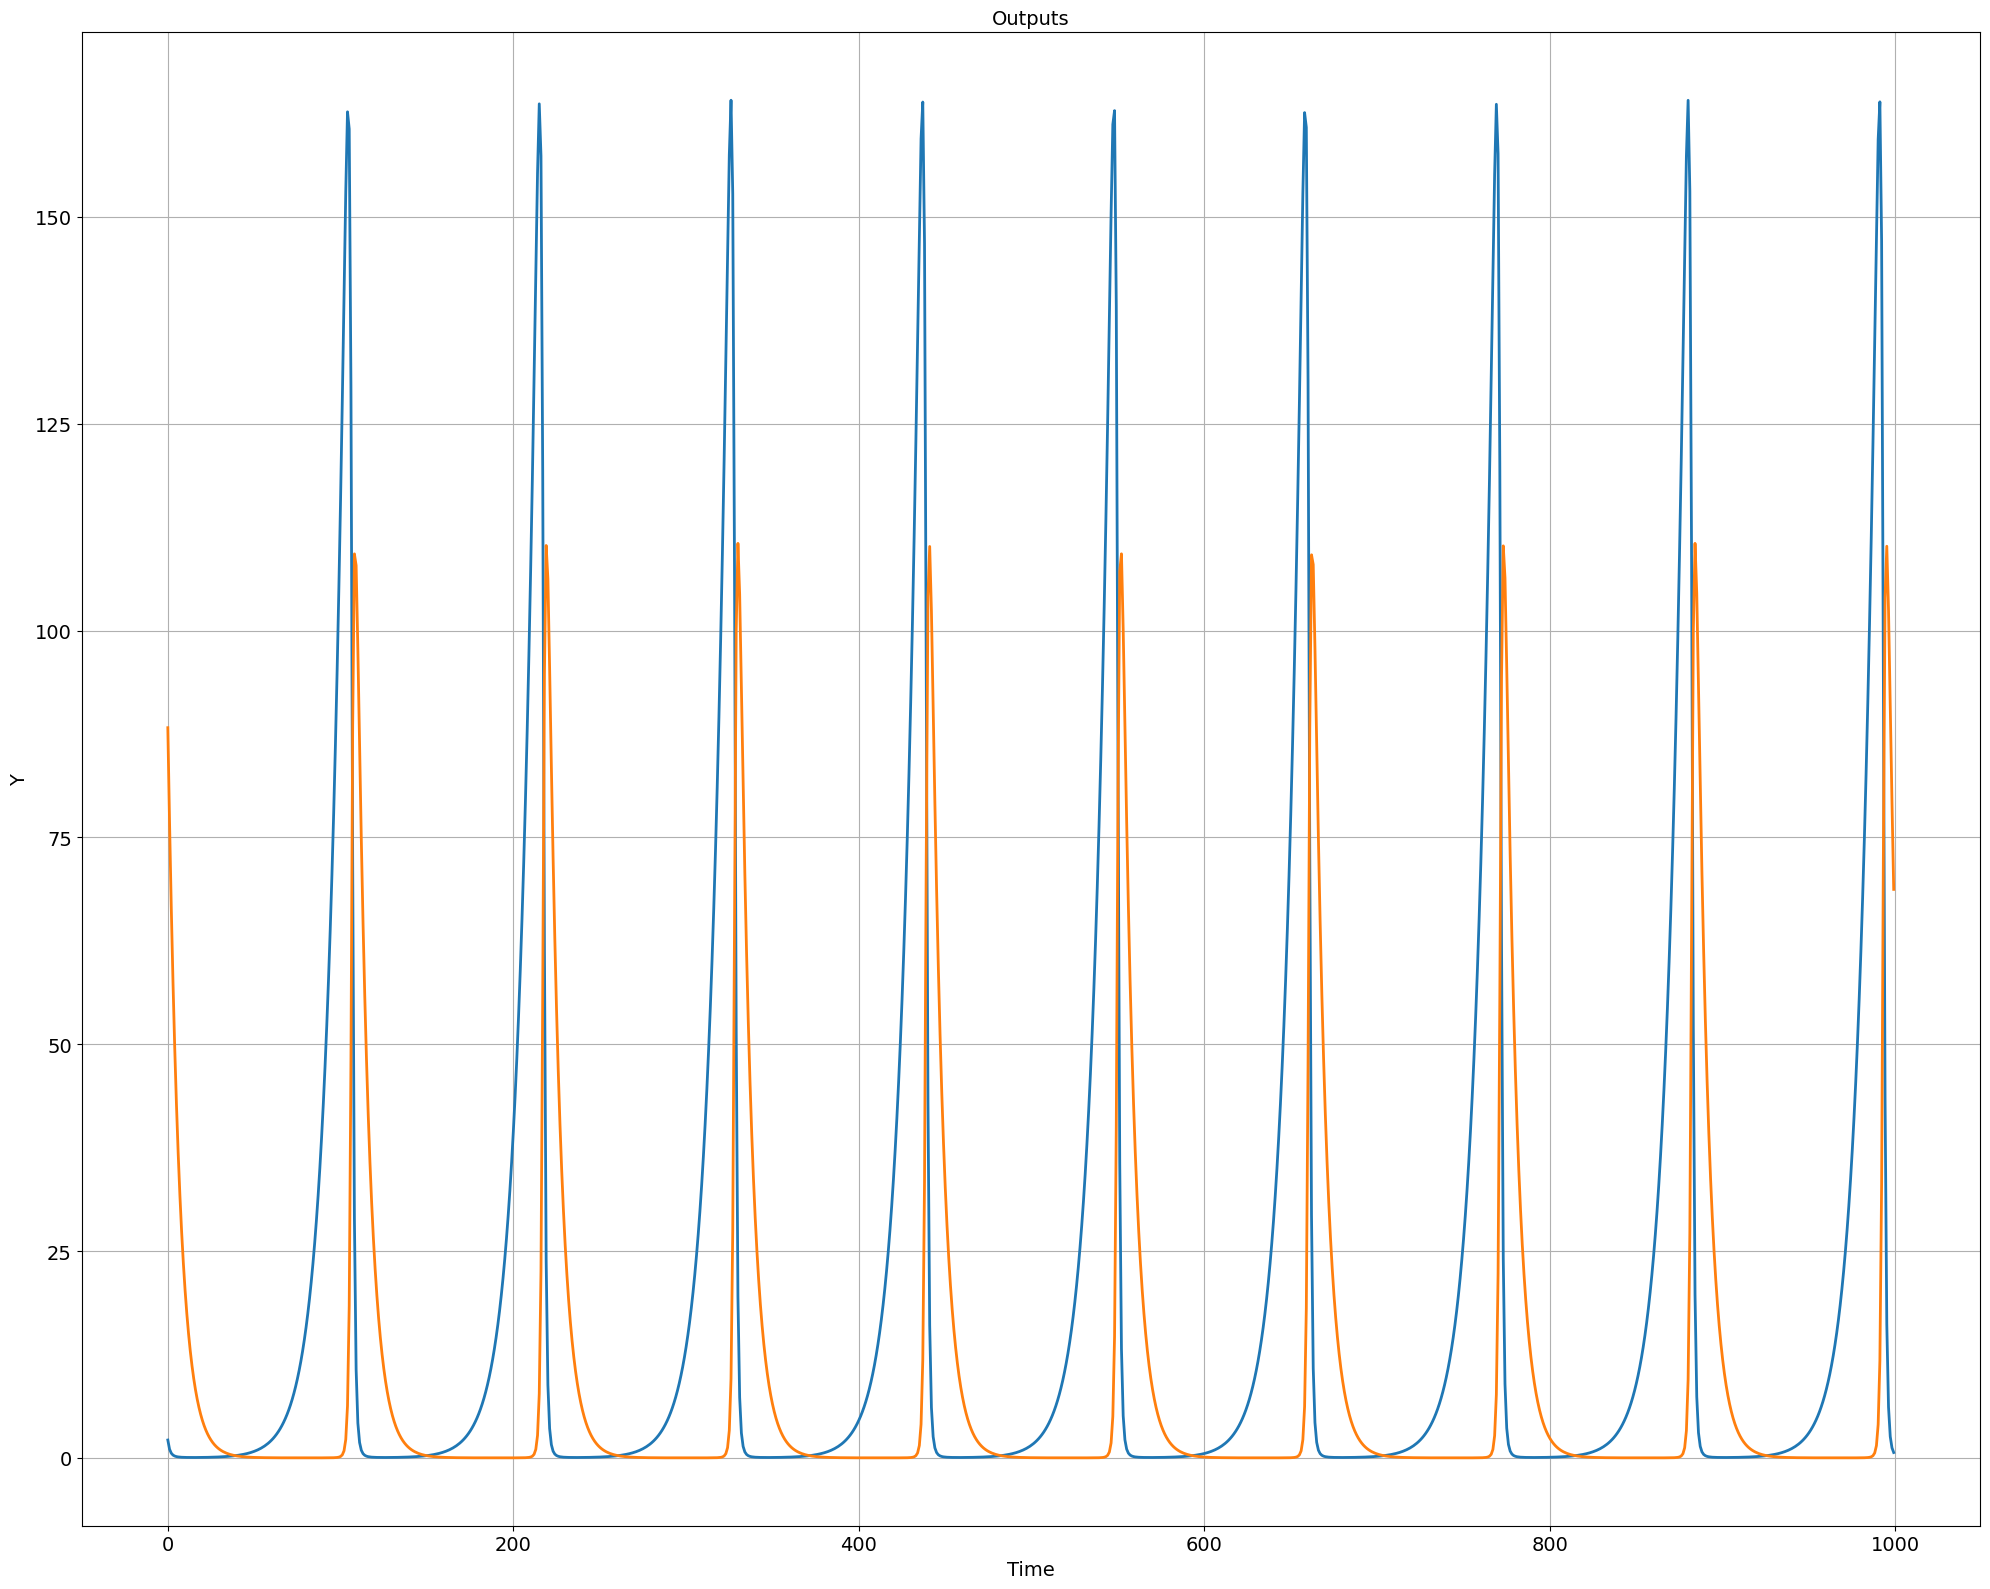

In [2]:

def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps #500
    length = (nsim//nsteps) * nsteps #1000
    ts = torch.linspace(0,1,nsteps)
    print('train sim ', train_sim['X'].shape)

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)

    print(trainX.shape)# N x nsteps x state_size 

    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data, trainX

torch.manual_seed(0)

# %%  ground truth system
system = psl.systems['LotkaVolterra']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
raw = modelSystem.simulate(nsim=1000, ts=ts)
plt.figure(figsize=(5,1))
plot.pltOL(Y=raw['X'])


We construct the NODE for the Lotka-Volterra system, creating a class inheriting from the neuromancer.ode ODESystem base class with learnable parameters

The standard Lotka-Volterra system, also known as the predator-prey model, describes the dynamics of two interacting species in a biological community. The system consists of two coupled ordinary differential equations (ODEs), typically represented as follows:

$$
\begin{align*}
\frac{dX}{dt} &= (\alpha X - \beta XY) dt  \\
\frac{dY}{dt} &= (\delta XY - \gamma Y) dt
\end{align*}
$$

In [3]:
class LotkaVolterraHybrid(ode.ODESystem):

    def __init__(self, block, insize=2, outsize=2):
        super().__init__(insize=insize, outsize=outsize)

        self.block = block
        self.alpha = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        assert self.block.in_features == 2
        assert self.block.out_features == 1

    def ode_equations(self, x):
        #Lotka Volterra equations
        x1 = x[:, [0]]
        x2 = x[:, [-1]]
        dx1 = self.alpha*x1 - self.beta*self.block(x)
        dx2 = self.delta*self.block(x) - self.gamma*x2
        return torch.cat([dx1, dx2], dim=-1)
    
    

Create the Neuromancer System to train this model:

In [4]:
nsim = 1000
nsteps = 2
bs = 10
train_loader, dev_loader, test_data, trainX = \
    get_data(modelSystem, nsim, nsteps, ts, bs)

# construct UDE model in Neuromancer
net = blocks.MLP(2, 1, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.GELU,
                    hsizes=4*[20])
fx = LotkaVolterraHybrid(net)

# integrate UDE model
fxRK4 = integrators.RK4(fx, h=ts)
# create symbolic UDE model
ude = Node(fxRK4, ['xn'], ['xn'], name='UDE')
dynamics_model = System([ude])

train sim  (1000, 2)
torch.Size([500, 2, 2])


We can train the above model using standard Neuromancer training set-up with reference and finite-difference loss functions:

In [ ]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]
# finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])

# trajectory tracking loss
reference_loss = (xhat == x)^2
reference_loss.name = "ref_loss"

# finite difference loss
fd_loss = 2.*(xFD == xhatFD)^2
fd_loss.name = 'FD_loss'

# aggregate list of objective terms and constraints
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])
# define neuromancer trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=100,
    epochs=500,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)
trainer.train()

## 2. Neural ODEs with Added Stochasticity

We now attempt to add stochasticiity to the Neural ODE case and train likewise. We will show that this model **cannot** be trained using our standard Neural ODE training setup and thus it will necessitate a different approach -- the Latent SDE shown in section 3. 

The stochastic Lotka-Volterra system is given by:

$$
\begin{align*}
\frac{dX}{dt} &= (\alpha X - \beta XY) dt + \sigma_1 dW_1 \\
\frac{dY}{dt} &= (\delta XY - \gamma Y) dt + \sigma_2 dW_2
\end{align*}
$$

where the additional terms are the diffusion coefficients.
How can we represent this in NeuroMANCER?

### SDE Base Class

We define a base class for SDEs here (as well as in sde.py). Note that the noise_type and sde_type are hardcoded to ensure correct functionality with torchSDE. Note that the two main functions required to be implemenented are the $f$ and $g$ functions as discussed earlier. The $f$ function is equivalent to the ODESystem's `ode_equations()` but with a different signature to be compatible with torchSDE. 

In [8]:
import abc
class BaseSDESystem(abc.ABC, nn.Module):
    """
    Base class for SDEs for integration with TorchSDE library
    """
    def __init__(self):
        super().__init__()
        self.noise_type = "diagonal" #only supports diagonal diffusion right now
        self.sde_type = "ito" #only supports Ito integrals right now
        self.in_features = 0 #for compatibility with Neuromancer integrators; unused
        self.out_features = 0

    @abc.abstractmethod
    def f(self, t, y):
        """
        Define the ordinary differential equations (ODEs) for the system.

        Args:
            t (Tensor): The current time (often unused)
            y (Tensor): The current state variables of the system.

        Returns:
            Tensor: The derivatives of the state variables with respect to time.
                    The output should be of shape [batch size x state size]
        """
        pass

    @abc.abstractmethod
    def g(self, t,y):
        """
        Define the diffusion equations for the system.

        Args:
            t (Tensor): The current time (often unused)
            y (Tensor): The current state variables of the system.

        Returns:
            Tensor: The diffusion coefficients per batch item (output is of size 
                    [batch size x state size]) for noise_type 'diagonal'
        """
        pass

We implement the stochastic Lotka-Volterra system with dummy parameters using this base class. We initially set the diffusion coefficients to zero to show that this simplifies to an ODE

In [9]:
class LotkaVolterraSDE(BaseSDESystem):
    def __init__(self, a, b, c, d, g_params):
        super().__init__()
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.g_params = g_params


    def f(self, t, x):
        x1 = x[:,[0]]
        x2 = x[:,[1]]
        dx1 = self.a * x1 - self.b * x1*x2
        dx2 = self.c * x1*x2 - self.d * x2
        return torch.cat([dx1, dx2], dim=-1)

    def g(self, t, x):
        return self.g_params

# Define parameters
a = 1.1    # Prey growth rate
b = 0.4   # Predation rate
c = 0.1   # Predator growth rate
d = 0.4   # Predator death rate
sigma1 = 0
sigma2 = 0
g_params = torch.tensor([[sigma1, sigma2]])
# Create the SDE model
sde = LotkaVolterraSDE(a, b, c, d, g_params)


Let's generate data from this ODE: 

In [10]:
# Define time span
import torchsde 

t_span = torch.linspace(0, 20, 2000)

# Initial condition
x0 = torch.tensor([10.0, 10.0]).unsqueeze(0) #[1x2]

# Integrate the SDE model
data = torchsde.sdeint(sde, x0, t_span, method='euler')


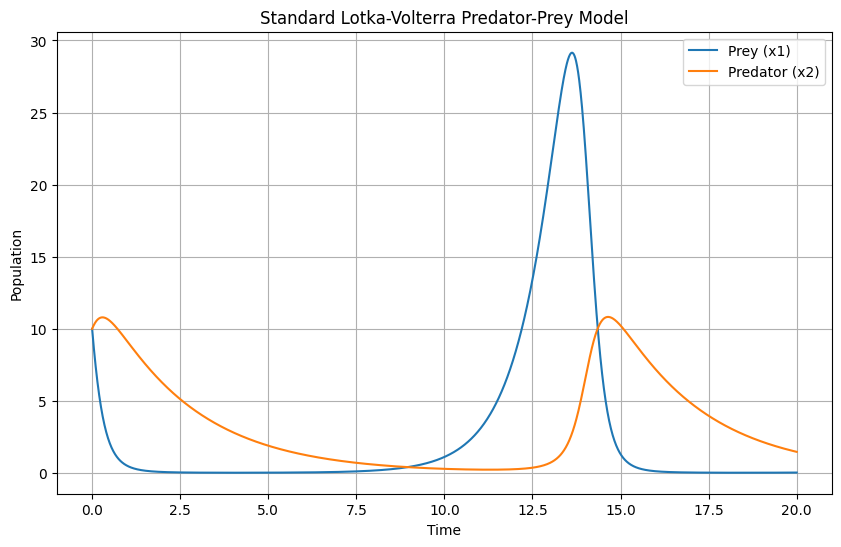

In [11]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, data[:, 0,0], label='Prey (x1)')
plt.plot(t_span, data[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Standard Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()

Now let's add some stochasticity: 

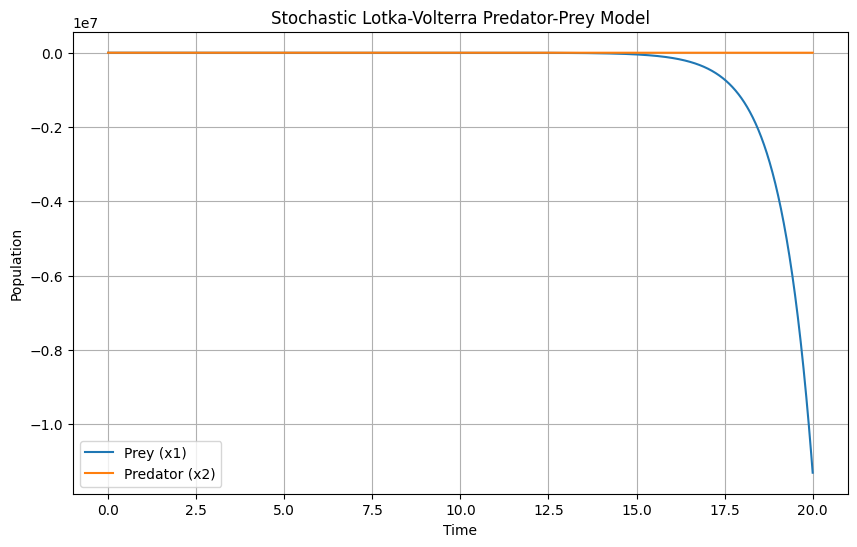

In [12]:
sigma1 = 1
sigma2 = 0
g_params = torch.tensor([[sigma1, sigma2]])
# Create the SDE model
sde = LotkaVolterraSDE(a, b, c, d, g_params)


t_span = torch.linspace(0, 20, 2000)

# Initial condition
x0 = torch.tensor([10.0, 10.0]).unsqueeze(0) #[1x2]

# Integrate the SDE model
data_stochastic = torchsde.sdeint(sde, x0, t_span, method='euler')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, data_stochastic[:, 0,0], label='Prey (x1)')
plt.plot(t_span, data_stochastic[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Stochastic Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()



#### Training a Neural SDE Using Reference Tracking + FD Loss

We now show how might attempt to train a Neural SDE to fit this data using our standard Neuromancer training procedure for Neural ODEs. First we construct a Neural SDE with learnable parameters. Note that to ensure the output size condition of $g$ we pass in batch size

In [41]:
class LotkaVolterraSDELearnable(BaseSDESystem):
    def __init__(self, block, batch_size):
        super().__init__()
        self.block = block 
        self.batch_size = batch_size
        self.alpha = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.g_params = nn.Parameter(torch.rand(self.batch_size, 2), requires_grad=True)


    def f(self, t, y):

        x1 = y[:, [0]]
        x2 = y[:, [-1]]

        dx1 = self.alpha*x1 - self.beta*self.block(y)
        dx2 = self.delta*self.block(y) - self.gamma*x2

        return torch.cat([dx1, dx2], dim=-1)
    
    def g(self, t, y):
        return self.g_params

# construct UDE model in Neuromancer
net = blocks.MLP(2, 1, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.GELU,
                    hsizes=4*[20])
sde_learnable = LotkaVolterraSDELearnable(block=net, batch_size=10)
    

We transform the shape of the Lotka-Volterra stochastic dataset from earlier to have a "rollout" of 2 steps (to mimic how training is done for the Neural ODE case)

In [42]:
nx = 2
nsim = 2000
nsteps = 2
nbatch = nsim//nsteps
length = (nsim//nsteps) * nsteps
bs = 10
x_train_lvs = data_stochastic.squeeze(1)[:length].reshape(nbatch, nsteps, nx)
train_data_lvs = DictDataset({'X': x_train_lvs, 'xn': x_train_lvs[:, 0:1, :]}, name='train')
train_loader_lvs = DataLoader(train_data_lvs, batch_size=bs,
                            collate_fn=train_data_lvs.collate_fn, shuffle=True)

x_dev_lvs = data_stochastic.squeeze(1)[:length].reshape(nbatch, nsteps, nx)
dev_data_lvs = DictDataset({'X': x_dev_lvs, 'xn': x_dev_lvs[:, 0:1, :]}, name='dev')
dev_loader_lvs = DataLoader(dev_data_lvs, batch_size=bs,
                            collate_fn=dev_data_lvs.collate_fn, shuffle=True)

x_test_lvs = data_stochastic.squeeze(1)[:length].reshape(1, nsim, nx)
test_data_lvs = DictDataset({'X': x_test_lvs, 'xn': x_test_lvs[:, 0:1, :]}, name='test')
test_data_lvs_2 = {'X': x_test_lvs, 'xn': x_test_lvs[:, 0:1, :]}

We define our integrator which is a NeuroMANCER wrapper for torchSDE's sdeint. To support rollout of two time steps we give it a time step tensor of three values.

In [43]:
class BasicSDEIntegrator(integrators.Integrator): 
    """
    Integrator (from TorchSDE) for basic/explicit SDE case where drift (f) and diffusion (g) terms are defined 
    Returns a single tensor of size (t, batch_size, state_size).

    Please see https://github.com/google-research/torchsde/blob/master/torchsde/_core/sdeint.py
    Currently only supports Euler integration. Choice of integration method is dependent 
    on integral type (Ito/Stratanovich) and drift/diffusion terms
    """
    def __init__(self, block ): 
        """
        :param block: (nn.Module) The BasicSDE block
        """
        super().__init__(block) 


    def integrate(self, x): 
        """
        x (xn) is the initial datastate of size (batch_size, 1, state_size)
        """
    
        t = torch.tensor([0.,0.01, 0.02], dtype=torch.float32) # t is the time-step vector over which to integrate. Hard coded right now to support rollout=2
        x = x.squeeze(1) #remove rollout dimension
        ys = torchsde.sdeint(self.block, x, t, method='euler')
        ys = ys.permute(1, 0, 2)
        return ys 

We **attempt** to train the model using reference tracking and finite-difference loss workflow. Note that this model **will not** train, and this is meant to serve a motivating reason to utilize the **Latent SDE** framework.

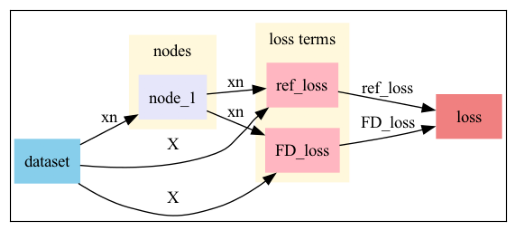

epoch: 0  train_loss: 280370720.0
epoch: 1  train_loss: 1259269.5
epoch: 2  train_loss: 3173.81787109375
epoch: 3  train_loss: 4029.0517578125
epoch: 4  train_loss: 2160.29150390625
epoch: 5  train_loss: 3204.1767578125
epoch: 6  train_loss: 2170.798095703125
epoch: 7  train_loss: 6954.16552734375
epoch: 8  train_loss: 4428.49951171875
epoch: 9  train_loss: 8502.1796875
epoch: 10  train_loss: 6236.666015625
epoch: 11  train_loss: 3221.912109375
epoch: 12  train_loss: 9576.5546875
epoch: 13  train_loss: 7514.75146484375
epoch: 14  train_loss: 2029.9180908203125
epoch: 15  train_loss: 3116.38720703125
epoch: 16  train_loss: 3704.189697265625
epoch: 17  train_loss: 6373.3974609375
epoch: 18  train_loss: 3277.477294921875
epoch: 19  train_loss: 2923.333984375
epoch: 20  train_loss: 2974.04150390625
epoch: 21  train_loss: 2931.277587890625
epoch: 22  train_loss: 3578.0654296875
epoch: 23  train_loss: 5337.3037109375
epoch: 24  train_loss: 2434.29296875
epoch: 25  train_loss: 6157.8764648437

<All keys matched successfully>

In [44]:
integrator = BasicSDEIntegrator(sde_learnable) 
model_sde = Node(integrator, input_keys=['xn'], output_keys=['xn'])
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = (xhat == x)^2
reference_loss.name = "ref_loss"

# finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])


# finite difference loss
fd_loss = 2.0*((xFD == xhatFD)^2)
fd_loss.name = 'FD_loss'

# %%
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([model_sde], loss)
# plot computational graph
problem.show()

# %%
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
trainer = Trainer(
    problem,
    train_loader_lvs,
    dev_loader_lvs,
    test_data_lvs_2,
    optimizer,
    patience=50,
    warmup=0,
    epochs=50,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    device='cpu', 
    epoch_verbose=1
)
# %%
best_model = trainer.train()
problem.load_state_dict(best_model)

In [45]:
with torch.no_grad(): 

    # Initial condition
    x0 = torch.ones([10,2])*10. #[batch_size x2] set of initial conditions
    # Integrate the SDE model
    data_stochastic_hat = torchsde.sdeint(sde_learnable, x0, t_span, method='euler')

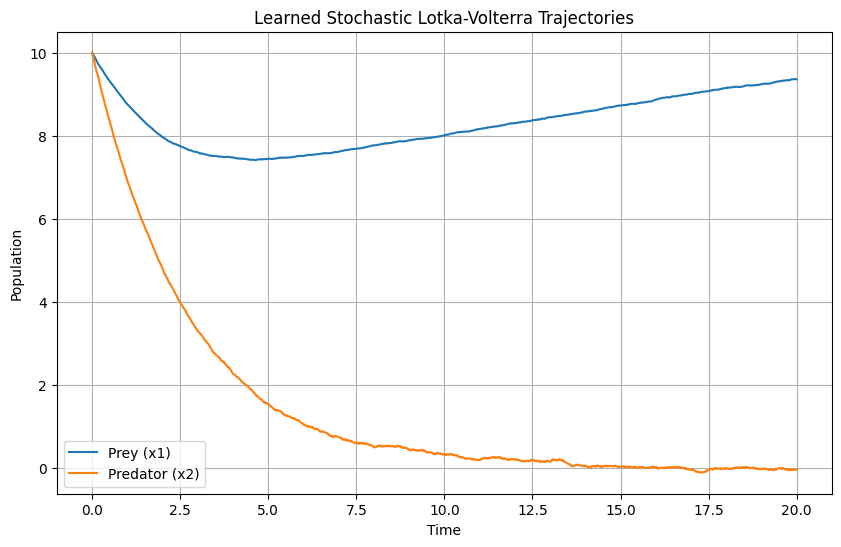

In [46]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, data_stochastic_hat[:, 0,0], label='Prey (x1)')
plt.plot(t_span, data_stochastic_hat[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Learned Stochastic Lotka-Volterra Trajectories')
plt.legend()
plt.grid(True)
plt.show()

It is clear using our rollout-based loss functions on observed stochastic data, similar to that in the Neural ODE case, does not work as it cannot capture the inherent randomness. Another way of putting it is the undeterministic nature of the system can cause the learned system to be unstable and blow up. Developing appropriate loss functions to ensure correctness and stability using this rollout framework is an open research question. Thus we necessitate the need to reformulate the above procedure + loss in a different way. We do so in a latent space and use a variational inference method to learn the stochastic data-generating distributions.

## 3. Latent SDEs

Using mean squared error (MSE) to train a neural SDE on time pairs might encounter challenges due to the stochastic nature of SDEs. While MSE is a common loss function used for deterministic systems, it may not be directly applicable to stochastic systems like SDEs. As discussed above, this is because these rollout-MSE -based losses do not capture the underlying uncertainty: 

* Ignoring Stochasticity: MSE only considers the deterministic part of the model and ignores the stochastic component represented by the diffusion term in the SDE. This can lead to suboptimal results as the model does not capture the inherent randomness in the system.

* Overfitting the Drift Term: MSE optimization might focus excessively on minimizing the errors in the drift term while neglecting the diffusion term. This can result in overfitting of the deterministic part of the model and underfitting of the stochastic part.

SDEs inherently involve randomness or uncertainty, typically represented by the stochastic terms in the differential equations. Instead of using refernence tracking + finite difference loss through our rollout mechanism, we can train the model using variational inference. 

#### Variaional Inference 
Variational inference allows us to capture this uncertainty by providing a probabilistic characterization of the latent variables' distribution. Instead of obtaining a single point estimate, variational inference provides a full probabilistic description, including measures of uncertainty such as confidence intervals or predictive distributions. Variational inference offers a solution to this problem by approximating the true posterior distribution with a simpler, parameterized distribution, often chosen from a family of distributions such as Gaussian distributions. This is done via an encoder network. The decoder network draws from samples of this learned, approximate posterior to reconstruct the data distribution. Using the KL divergence, between these distributions, we learn the latent space's parameters known as the variational parameters. 

The Latent SDE is essentially a variational "autoencoder" where instead of seeking resynthesize samples corresponding to the "same time" instance, it tries to reconstruct future samples given the current dynamics of the system, where the dynamics are known to be modeled via a SDE. To do this, the latent space is **itself** going to be governed via an SDE and we perform integration on the latent space to synthesize forward-looking samples. 

#### Latent SDE Architecture

We now define the architecture for the Latent SDE and train on a 3D stochastic Lorenz attractor dataset. Code adapted from https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py

1. **Encoder**:
   - The encoder maps each input data point $x$ to a distribution over latent variables $z$. This distribution is typically Gaussian with mean $\mu$ and standard deviation $\sigma$.
   $$
   q_{\phi}(z | x) = \mathcal{N}(\mu_{\phi}(x), \sigma_{\phi}(x))
   $$
   - Here, $\mu_{\phi}(x)$ and $\sigma_{\phi}(x)$ are the mean and standard deviation parameters of the Gaussian distribution, which are output by the encoder neural network parameterized by $\phi$.

2. **Latent Dynamics**:
   - The latent variables $z$ evolve over time according to a stochastic differential equation (SDE). The dynamics of $z$ are governed by drift and diffusion functions, similar to the SDE for the observed data $x$.
   $$
   dz_t = f(z_t, t) \, dt + G(z_t, t) \, dW_t
   $$
   - $f(z_t, t)$ represents the drift component, determining the deterministic evolution of the latent variables.
   - $G(z_t, t)$ represents the diffusion component, introducing stochasticity into the latent dynamics.
   - $dW_t$ is the increment of a Wiener process (Brownian motion), representing random noise.

3. **Decoder**:
   - The decoder takes samples from the latent space $z$ and maps them back to the data space $x$. It models the conditional distribution of $x$ given $z$.
   $$
   p_{\theta}(x | z)
   $$
   - The decoder neural network, parameterized by $\theta$, outputs the parameters of the conditional distribution $p_{\theta}(x | z)$, such as the mean and variance of a Gaussian distribution or the parameters of a Bernoulli distribution for binary data.

4. **Latent Variable Prior**:
   - We assume a prior distribution over the latent variables $z$. This distribution is typically chosen to be a standard Gaussian.
   $$
   p(z) = \mathcal{N}(0, I)
   $$

      though in TorchSDE's framework (and as shown in the code below), these are learnable parameters pz0_mean and pz0_logstd

5. **Objective Function**:
   - The objective function for training the Latent SDE model is similar to the ELBO in VAEs but now includes the evolution of latent variables governed by the SDE.
   $$
   \text{ELBO}(\theta, \phi; x) = \mathbb{E}_{q_{\phi}(z | x)} [\log p_{\theta}(x | z)] - \text{KL}[q_{\phi}(z | x) || p(z)]
   $$
   - The first term represents the reconstruction loss, measuring how well the decoder reconstructs the input data $x$ from the latent variable samples $z$.
   - The second term is the KL divergence between the approximate posterior $q_{\phi}(z | x)$ and the prior $p(z)$, which encourages the approximate posterior to match the prior.


### Functions to generate data from a Lorenz attractor

We define the 3D stochastic Lorenz attractor model. This model as appropriate $f$ and $g$ functions defined. To produce data samples we integrate this using the Euler-Murayama integrator from TorchSDE library

In [92]:

class StochasticLorenzAttractor(BaseSDESystem):
    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.1, .28, .3)):
        super().__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return torch.cat([g1, g2, g3], dim=1)
    
    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs
stochastic_lorenz_model = StochasticLorenzAttractor()

## Neuromancer Integration

As per the NeuroMANCER x Lightning workflow, generate the data_setup_function and return the DictDatasets. Note that we only have a train dataset here, so we return `None` for dev/test datasets

In [100]:
def make_dataset(t0, t1, batch_size, noise_std, steps=100):
    _y0 = torch.randn(batch_size, 3)
    ts = torch.linspace(t0, t1, steps=steps)
    xs = stochastic_lorenz_model.sample(_y0, ts, noise_std, normalize=True)
    train_data = DictDataset({'xs':xs},name='train')
    return train_data, None, None, batch_size
    

Define some experimental parameters

In [101]:
data_size = 3
batch_size=1024
latent_size=4
context_size=64
hidden_size=128
lr_init=1e-2
t0=0.
t1=2.
lr_gamma=0.997
num_iters=1
kl_anneal_iters=1000
pause_every=50
noise_std=0.01
method="euler"
steps = 100 # number of time steps

Based on the aforementioned discussion as well as equations above for the latent SDE, we now define the model architecture consisting of a LatentSDE Encoder and Decoder. For integration in the latent space we use a LatentSDE Integrator.

In [104]:
class Encoder(nn.Module):
    """
    Encoder module to handle time-series data (as in the case of stochastic data and SDE)
    GRU is used to handle mapping to latent space in this case
    This class is used only in LatentSDE_Encoder
    """
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, _ = self.gru(inp)
        out = self.lin(out)
        return out
    
class LatentSDE_Encoder(BaseSDESystem):
    def __init__(self, data_size, latent_size, context_size, hidden_size, ts, adjoint=False):
        """
        LatentSDE_Encoder is a neural network module designed for encoding time-series data into a latent space representation,
        which is then used to model the system dynamics using Stochastic Differential Equations (SDEs).

        The primary purpose of this class is to transform high-dimensional time-series data into a lower-dimensional latent space
        while capturing the underlying stochastic dynamics. This transformation facilitates efficient modeling, prediction, and
        inference of complex temporal processes. 

        Taken from https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py and modified to support 
        NeuroMANCER library

        :param data_size: (int) state size of the data 
        :param latent_size: (int) input latent size for the encoder 
        :param context_size: (int) size of context vector (output of encoder)
        :param hidden_size: (int) size of the hidden layer of encoder 
        :param ts: (tensor) tensor of timesteps over which data should be predicted

        """
        super().__init__()

        self.adjoint = adjoint

        # Encoder.
        self.encoder = Encoder(input_size=data_size, hidden_size=hidden_size, output_size=context_size)
        self.qz0_net = nn.Linear(context_size, latent_size + latent_size) #Layer to return mean and variance of the parameterized latent space

        # Decoder.
        self.f_net = nn.Sequential(
            nn.Linear(latent_size + context_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        self.h_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # This needs to be an element-wise function for the SDE to satisfy diagonal noise.
        self.g_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )
        self.projector = nn.Linear(latent_size, data_size)

        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))

        self._ctx = None
        self.ts = ts

    def contextualize(self, ctx):
        self._ctx = ctx  # A tuple of tensors of sizes (T,), (T, batch_size, d).

    def f(self, t, y):
        ts, ctx = self._ctx

        i = min(torch.searchsorted(ts, t, right=True), len(ts) - 1)

        return self.f_net(torch.cat((y, ctx[i]), dim=1))

    def h(self, t, y):
        return self.h_net(y)

    def g(self, t, y):  # Diagonal diffusion.
        y = torch.split(y, split_size_or_sections=1, dim=1)
        out = [g_net_i(y_i) for (g_net_i, y_i) in zip(self.g_nets, y)]
        return torch.cat(out, dim=1)

    def forward(self, xs):
        # Contextualization is only needed for posterior inference.
        ctx = self.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        self.contextualize((self.ts, ctx))

        qz0_mean, qz0_logstd = self.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)
        if not self.adjoint:
            return z0, xs, self.ts, qz0_mean, qz0_logstd
        else:
            adjoint_params = (
                    (ctx,) +
                    tuple(self.f_net.parameters()) + tuple(self.g_nets.parameters()) + tuple(self.h_net.parameters())
            )
            return z0, xs, self.ts, qz0_mean, qz0_logstd, adjoint_params

class LatentSDE_Decoder(BaseSDESystem):
    """
    Second part of Wrapper for torchsde's Latent SDE class to integrate with Neuromancer. This takes in output of
    LatentSDEIntegrator and decodes it back into the "real" data space and also outputs associated Gaussian distributions
    to be used in the final loss function.
    Please see https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py

    :param data_size: (int) state size of the data 
    :param latent_size: (int) input latent size for the encoder 
    :param noise_std: (float) standard deviation of the Gaussian noise applied during decoding
    """
    def __init__(self, data_size, latent_size, noise_std):
        super().__init__()
        self.noise_std = noise_std
        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))
        self.projector = nn.Linear(latent_size, data_size)
    
    def f(self, t, y): 
        pass #unused 
    
    def g(self, t, y): 
        pass #unused

    def forward(self, xs, zs, log_ratio, qz0_mean, qz0_logstd):
        _xs = self.projector(zs)
        xs_dist = Normal(loc=_xs, scale=self.noise_std)
        log_pxs = xs_dist.log_prob(xs).sum(dim=(0, 2)).mean(dim=0)

        qz0 = torch.distributions.Normal(loc=qz0_mean, scale=qz0_logstd.exp())
        pz0 = torch.distributions.Normal(loc=self.pz0_mean, scale=self.pz0_logstd.exp())
        logqp0 = torch.distributions.kl_divergence(qz0, pz0).sum(dim=1).mean(dim=0)
        logqp_path = log_ratio.sum(dim=0).mean(dim=0)
        return _xs, log_pxs, logqp0 + logqp_path, log_ratio

Define Neuromancer components, variables, and problem to train the LatentSDE. We define two nodes -- one for encoding and integrating, one for decoding. Upon training, this LatentSDE will generate new samples that exhibit the behavior of the Lorenz attractor training data. For this example, we set `adjoint` to `False` (do not use the adjoint sensitivity method). This is because this method seems to be significantly slower. 

Also note that we need to pass in the timestep tensor to our `LatentSDE_Encoder`, and as a result need to also define it outside the `make_dataset()` function. We note that this is not the cleanest code and breaks the data abstraction. Additional features will be added to mitigate this.

In [105]:
ts = torch.linspace(t0, t1, steps=steps)

sde_encoder = LatentSDE_Encoder(data_size, latent_size, context_size, hidden_size, ts=ts, adjoint=False) 
integrator = integrators.LatentSDEIntegrator(sde_encoder, adjoint=False)
model_1 = Node(integrator, input_keys=['xs'], output_keys=['zs', 'z0', 'log_ratio',  'xs', 'qz0_mean', 'qz0_logstd'], name='m1')
sde_decoder = LatentSDE_Decoder(3, latent_size, noise_std=noise_std)
model_2 = Node(sde_decoder, input_keys=['xs', 'zs', 'log_ratio', 'qz0_mean', 'qz0_logstd'], output_keys=['xs_hat', 'log_pxs', 'sum_term', 'log_ratio'], name='m2' )



log_ratio = variable('log_ratio')
log_pxs = variable('log_pxs')

# NeuroMANCER loss function format
loss = (-1.0*log_pxs + log_ratio) == 0.0

# aggregate list of objective terms and constraints
objectives = [loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([model_1, model_2], loss)

We now define helper visualization function (again see https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py) that will fire every N epochs in our training loop. This visualization will allow us to see the learned Lorenz attractor samples 

In [106]:
# Fix the same Brownian motion for visualization.
bm_vis = torchsde.BrownianInterval(
    t0=t0, t1=t1, size=(batch_size, latent_size,), device='cpu', levy_area_approximation="space-time")

# 
def vis(data_dict, problem, bm_vis, img_path, num_samples=10):
    encoder, decoder = problem.nodes[0], problem.nodes[1] #extract the encoder and decoder from our problem

    fig = plt.figure(figsize=(20, 9))
    gs = gridspec.GridSpec(1, 2)
    ax00 = fig.add_subplot(gs[0, 0], projection='3d')
    ax01 = fig.add_subplot(gs[0, 1], projection='3d')

    xs = data_dict['xs'] #pull out data sample from the DictDataset
    # Left plot: data.
    z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
    [ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :10, 0], marker='x')
    ax00.set_yticklabels([])
    ax00.set_xticklabels([])
    ax00.set_zticklabels([])
    ax00.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax00.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax00.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax00.set_title('Data', fontsize=20)
    xlim = ax00.get_xlim()
    ylim = ax00.get_ylim()
    zlim = ax00.get_zlim()

    # Right plot: samples from learned model.
    mydata = data_dict
    output = decoder(encoder(mydata))
    xs_hat = output['xs_hat'].detach().cpu().numpy() 
    #xs = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis).cpu().numpy()
    z1, z2, z3 = np.split(xs_hat, indices_or_sections=3, axis=-1)

    [ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :10, 0], marker='x')
    ax01.set_yticklabels([])
    ax01.set_xticklabels([])
    ax01.set_zticklabels([])
    ax01.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax01.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax01.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax01.set_title('Samples', fontsize=20)
    ax01.set_xlim(xlim)
    ax01.set_ylim(ylim)
    ax01.set_zlim(zlim)

    plt.savefig(img_path)
    plt.close()

### Neuromancer training the problem to learn the stochastic process

We now train and visualize results using Lightning workflow

In [107]:

# Fix the same Brownian motion for visualization.
bm_vis = torchsde.BrownianInterval(
    t0=t0, t1=t1, size=(batch_size, latent_size,), device='cpu', levy_area_approximation="space-time")

# Define the custom_training_step to support visualization. 
def custom_training_step(model, batch): 
    output = model.problem(batch)
    loss = output[model.train_metric]
    img_path = os.path.join('', f'current_epoch_{model.current_epoch:06d}.pdf')
    if model.current_epoch % 50 == 0: 
        vis(batch,  model.problem, bm_vis, img_path, num_samples=10)
    return loss


optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
lit_trainer = LitTrainer(epochs=300, accelerator='cpu', train_metric='train_loss', 
                         dev_metric='train_loss', eval_metric='train_loss', test_metric='train_loss',
                         custom_optimizer=optimizer, custom_training_step=custom_training_step)



lit_trainer.fit(problem=problem, data_setup_function=make_dataset,  t0=t0, t1=t1, batch_size=batch_size, noise_std=noise_std, steps=steps)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/birm560/opt/anaconda3/envs/neuromancer9/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs exists and is not empty.

  | Name    | Type    | Params
------------------------------------
0 | problem | Problem | 104 K 
------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.420     Total estimated model params size (MB)


USING BATCH SIZE  1024
USING LEARNING RATE  0.001
                                                  

/Users/birm560/opt/anaconda3/envs/neuromancer9/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/birm560/opt/anaconda3/envs/neuromancer9/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/Users/birm560/opt/anaconda3/envs/neuromancer9/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/birm560/opt/anaconda3/envs/neuromancer9/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298:

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([99, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/Users/birm560/opt/anaconda3/envs/neuromancer9/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 100. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 1/1 [00:11<00:00,  0.09it/s, v_num=8, train_loss_step=2.49e+6, train_loss_epoch=2.49e+6]

Epoch 0, global step 1: 'train_loss' reached 2491397.25000 (best 2491397.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=0-step=1.ckpt' as top 1


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8, train_loss_step=2.49e+6, train_loss_epoch=2.49e+6]        

/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([99, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


Epoch 1: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=8, train_loss_step=2.2e+6, train_loss_epoch=2.2e+6]  

Epoch 1, global step 2: 'train_loss' reached 2197733.75000 (best 2197733.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=1-step=2.ckpt' as top 1


Epoch 2: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=8, train_loss_step=2.11e+6, train_loss_epoch=2.11e+6]

Epoch 2, global step 3: 'train_loss' reached 2106942.25000 (best 2106942.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=2-step=3.ckpt' as top 1


Epoch 3: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=8, train_loss_step=2.04e+6, train_loss_epoch=2.04e+6]

Epoch 3, global step 4: 'train_loss' reached 2037659.62500 (best 2037659.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=3-step=4.ckpt' as top 1


Epoch 4: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=8, train_loss_step=1.94e+6, train_loss_epoch=1.94e+6]

Epoch 4, global step 5: 'train_loss' reached 1942911.87500 (best 1942911.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=4-step=5.ckpt' as top 1


Epoch 5: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=8, train_loss_step=1.9e+6, train_loss_epoch=1.9e+6]  

Epoch 5, global step 6: 'train_loss' reached 1903310.25000 (best 1903310.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=5-step=6.ckpt' as top 1


Epoch 6: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.86e+6, train_loss_epoch=1.86e+6]

Epoch 6, global step 7: 'train_loss' reached 1855765.87500 (best 1855765.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=6-step=7.ckpt' as top 1


Epoch 7: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=1.82e+6, train_loss_epoch=1.82e+6]

Epoch 7, global step 8: 'train_loss' reached 1819223.62500 (best 1819223.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=7-step=8.ckpt' as top 1


Epoch 8: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.75e+6, train_loss_epoch=1.75e+6]

Epoch 8, global step 9: 'train_loss' reached 1752186.12500 (best 1752186.12500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=8-step=9.ckpt' as top 1


Epoch 9: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.73e+6, train_loss_epoch=1.73e+6]

Epoch 9, global step 10: 'train_loss' reached 1726925.75000 (best 1726925.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=9-step=10.ckpt' as top 1


Epoch 10: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=1.65e+6, train_loss_epoch=1.65e+6]

Epoch 10, global step 11: 'train_loss' reached 1650899.50000 (best 1650899.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=10-step=11.ckpt' as top 1


Epoch 11: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=1.65e+6, train_loss_epoch=1.65e+6]

Epoch 11, global step 12: 'train_loss' was not in top 1


Epoch 12: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=1.59e+6, train_loss_epoch=1.59e+6]

Epoch 12, global step 13: 'train_loss' reached 1594603.37500 (best 1594603.37500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=12-step=13.ckpt' as top 1


Epoch 13: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.63e+6, train_loss_epoch=1.63e+6]

Epoch 13, global step 14: 'train_loss' was not in top 1


Epoch 14: 100%|██████████| 1/1 [00:03<00:00,  0.25it/s, v_num=8, train_loss_step=1.57e+6, train_loss_epoch=1.57e+6]

Epoch 14, global step 15: 'train_loss' reached 1565642.12500 (best 1565642.12500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=14-step=15.ckpt' as top 1


Epoch 15: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=8, train_loss_step=1.61e+6, train_loss_epoch=1.61e+6]

Epoch 15, global step 16: 'train_loss' was not in top 1


Epoch 16: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.54e+6, train_loss_epoch=1.54e+6]

Epoch 16, global step 17: 'train_loss' reached 1542609.62500 (best 1542609.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=16-step=17.ckpt' as top 1


Epoch 17: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=8, train_loss_step=1.6e+6, train_loss_epoch=1.6e+6]  

Epoch 17, global step 18: 'train_loss' was not in top 1


Epoch 18: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=8, train_loss_step=1.53e+6, train_loss_epoch=1.53e+6]

Epoch 18, global step 19: 'train_loss' reached 1525671.62500 (best 1525671.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=18-step=19.ckpt' as top 1


Epoch 19: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=8, train_loss_step=1.59e+6, train_loss_epoch=1.59e+6]

Epoch 19, global step 20: 'train_loss' was not in top 1


Epoch 20: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=8, train_loss_step=1.51e+6, train_loss_epoch=1.51e+6]

Epoch 20, global step 21: 'train_loss' reached 1510765.87500 (best 1510765.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=20-step=21.ckpt' as top 1


Epoch 21: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=8, train_loss_step=1.56e+6, train_loss_epoch=1.56e+6]

Epoch 21, global step 22: 'train_loss' was not in top 1


Epoch 22: 100%|██████████| 1/1 [00:03<00:00,  0.25it/s, v_num=8, train_loss_step=1.49e+6, train_loss_epoch=1.49e+6]

Epoch 22, global step 23: 'train_loss' reached 1486163.87500 (best 1486163.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=22-step=23.ckpt' as top 1


Epoch 23: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=1.53e+6, train_loss_epoch=1.53e+6]

Epoch 23, global step 24: 'train_loss' was not in top 1


Epoch 24: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.47e+6, train_loss_epoch=1.47e+6]

Epoch 24, global step 25: 'train_loss' reached 1465629.75000 (best 1465629.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=24-step=25.ckpt' as top 1


Epoch 25: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.49e+6, train_loss_epoch=1.49e+6]

Epoch 25, global step 26: 'train_loss' was not in top 1


Epoch 26: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.44e+6, train_loss_epoch=1.44e+6]

Epoch 26, global step 27: 'train_loss' reached 1438116.75000 (best 1438116.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=26-step=27.ckpt' as top 1


Epoch 27: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.45e+6, train_loss_epoch=1.45e+6]

Epoch 27, global step 28: 'train_loss' was not in top 1


Epoch 28: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=8, train_loss_step=1.41e+6, train_loss_epoch=1.41e+6]

Epoch 28, global step 29: 'train_loss' reached 1409233.87500 (best 1409233.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=28-step=29.ckpt' as top 1


Epoch 29: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.41e+6, train_loss_epoch=1.41e+6]

Epoch 29, global step 30: 'train_loss' was not in top 1


Epoch 30: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.38e+6, train_loss_epoch=1.38e+6]

Epoch 30, global step 31: 'train_loss' reached 1379124.50000 (best 1379124.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=30-step=31.ckpt' as top 1


Epoch 31: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=1.38e+6, train_loss_epoch=1.38e+6]

Epoch 31, global step 32: 'train_loss' reached 1375999.87500 (best 1375999.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=31-step=32.ckpt' as top 1


Epoch 32: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.34e+6, train_loss_epoch=1.34e+6]

Epoch 32, global step 33: 'train_loss' reached 1344039.25000 (best 1344039.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=32-step=33.ckpt' as top 1


Epoch 33: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.33e+6, train_loss_epoch=1.33e+6]

Epoch 33, global step 34: 'train_loss' reached 1333839.25000 (best 1333839.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=33-step=34.ckpt' as top 1


Epoch 34: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.31e+6, train_loss_epoch=1.31e+6]

Epoch 34, global step 35: 'train_loss' reached 1314711.62500 (best 1314711.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=34-step=35.ckpt' as top 1


Epoch 35: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.3e+6, train_loss_epoch=1.3e+6]  

Epoch 35, global step 36: 'train_loss' reached 1301437.87500 (best 1301437.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=35-step=36.ckpt' as top 1


Epoch 36: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.29e+6, train_loss_epoch=1.29e+6]

Epoch 36, global step 37: 'train_loss' reached 1287377.25000 (best 1287377.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=36-step=37.ckpt' as top 1


Epoch 37: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.27e+6, train_loss_epoch=1.27e+6]

Epoch 37, global step 38: 'train_loss' reached 1265593.50000 (best 1265593.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=37-step=38.ckpt' as top 1


Epoch 38: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.25e+6, train_loss_epoch=1.25e+6]

Epoch 38, global step 39: 'train_loss' reached 1252697.62500 (best 1252697.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=38-step=39.ckpt' as top 1


Epoch 39: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=1.23e+6, train_loss_epoch=1.23e+6]

Epoch 39, global step 40: 'train_loss' reached 1232948.37500 (best 1232948.37500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=39-step=40.ckpt' as top 1


Epoch 40: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.23e+6, train_loss_epoch=1.23e+6]

Epoch 40, global step 41: 'train_loss' reached 1228424.62500 (best 1228424.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=40-step=41.ckpt' as top 1


Epoch 41: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=1.21e+6, train_loss_epoch=1.21e+6]

Epoch 41, global step 42: 'train_loss' reached 1208733.75000 (best 1208733.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=41-step=42.ckpt' as top 1


Epoch 42: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.22e+6, train_loss_epoch=1.22e+6]

Epoch 42, global step 43: 'train_loss' was not in top 1


Epoch 43: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.21e+6, train_loss_epoch=1.21e+6]

Epoch 43, global step 44: 'train_loss' was not in top 1


Epoch 44: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=1.22e+6, train_loss_epoch=1.22e+6]

Epoch 44, global step 45: 'train_loss' was not in top 1


Epoch 45: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=1.17e+6, train_loss_epoch=1.17e+6]

Epoch 45, global step 46: 'train_loss' reached 1167783.37500 (best 1167783.37500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=45-step=46.ckpt' as top 1


Epoch 46: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.18e+6, train_loss_epoch=1.18e+6]

Epoch 46, global step 47: 'train_loss' was not in top 1


Epoch 47: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.16e+6, train_loss_epoch=1.16e+6]

Epoch 47, global step 48: 'train_loss' reached 1156787.37500 (best 1156787.37500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=47-step=48.ckpt' as top 1


Epoch 48: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=1.19e+6, train_loss_epoch=1.19e+6]

Epoch 48, global step 49: 'train_loss' was not in top 1


Epoch 49: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=1.21e+6, train_loss_epoch=1.21e+6]

Epoch 49, global step 50: 'train_loss' was not in top 1


Epoch 50: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.26e+6, train_loss_epoch=1.26e+6]

Epoch 50, global step 51: 'train_loss' was not in top 1


Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8, train_loss_step=1.26e+6, train_loss_epoch=1.26e+6]        

/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([99, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


Epoch 51: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.15e+6, train_loss_epoch=1.15e+6]

Epoch 51, global step 52: 'train_loss' reached 1153392.87500 (best 1153392.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=51-step=52.ckpt' as top 1


Epoch 52: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.18e+6, train_loss_epoch=1.18e+6]

Epoch 52, global step 53: 'train_loss' was not in top 1


Epoch 53: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=8, train_loss_step=1.13e+6, train_loss_epoch=1.13e+6]

Epoch 53, global step 54: 'train_loss' reached 1130628.00000 (best 1130628.00000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=53-step=54.ckpt' as top 1


Epoch 54: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.17e+6, train_loss_epoch=1.17e+6]

Epoch 54, global step 55: 'train_loss' was not in top 1


Epoch 55: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.12e+6, train_loss_epoch=1.12e+6]

Epoch 55, global step 56: 'train_loss' reached 1122421.00000 (best 1122421.00000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=55-step=56.ckpt' as top 1


Epoch 56: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.16e+6, train_loss_epoch=1.16e+6]

Epoch 56, global step 57: 'train_loss' was not in top 1


Epoch 57: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.12e+6, train_loss_epoch=1.12e+6]

Epoch 57, global step 58: 'train_loss' reached 1118608.12500 (best 1118608.12500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=57-step=58.ckpt' as top 1


Epoch 58: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=1.16e+6, train_loss_epoch=1.16e+6]

Epoch 58, global step 59: 'train_loss' was not in top 1


Epoch 59: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.12e+6, train_loss_epoch=1.12e+6]

Epoch 59, global step 60: 'train_loss' reached 1116679.25000 (best 1116679.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=59-step=60.ckpt' as top 1


Epoch 60: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.17e+6, train_loss_epoch=1.17e+6]

Epoch 60, global step 61: 'train_loss' was not in top 1


Epoch 61: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.12e+6, train_loss_epoch=1.12e+6]

Epoch 61, global step 62: 'train_loss' was not in top 1


Epoch 62: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.17e+6, train_loss_epoch=1.17e+6]

Epoch 62, global step 63: 'train_loss' was not in top 1


Epoch 63: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.1e+6, train_loss_epoch=1.1e+6]  

Epoch 63, global step 64: 'train_loss' reached 1100457.75000 (best 1100457.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=63-step=64.ckpt' as top 1


Epoch 64: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.15e+6, train_loss_epoch=1.15e+6]

Epoch 64, global step 65: 'train_loss' was not in top 1


Epoch 65: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=1.09e+6, train_loss_epoch=1.09e+6]

Epoch 65, global step 66: 'train_loss' reached 1086657.12500 (best 1086657.12500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=65-step=66.ckpt' as top 1


Epoch 66: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=1.15e+6, train_loss_epoch=1.15e+6]

Epoch 66, global step 67: 'train_loss' was not in top 1


Epoch 67: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.08e+6, train_loss_epoch=1.08e+6]

Epoch 67, global step 68: 'train_loss' reached 1082844.50000 (best 1082844.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=67-step=68.ckpt' as top 1


Epoch 68: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.2e+6, train_loss_epoch=1.2e+6]  

Epoch 68, global step 69: 'train_loss' was not in top 1


Epoch 69: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.12e+6, train_loss_epoch=1.12e+6]

Epoch 69, global step 70: 'train_loss' was not in top 1


Epoch 70: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.25e+6, train_loss_epoch=1.25e+6]

Epoch 70, global step 71: 'train_loss' was not in top 1


Epoch 71: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.08e+6, train_loss_epoch=1.08e+6]

Epoch 71, global step 72: 'train_loss' reached 1082627.12500 (best 1082627.12500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=71-step=72.ckpt' as top 1


Epoch 72: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.16e+6, train_loss_epoch=1.16e+6]

Epoch 72, global step 73: 'train_loss' was not in top 1


Epoch 73: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.07e+6, train_loss_epoch=1.07e+6]

Epoch 73, global step 74: 'train_loss' reached 1074187.50000 (best 1074187.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=73-step=74.ckpt' as top 1


Epoch 74: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.14e+6, train_loss_epoch=1.14e+6]

Epoch 74, global step 75: 'train_loss' was not in top 1


Epoch 75: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.06e+6, train_loss_epoch=1.06e+6]

Epoch 75, global step 76: 'train_loss' reached 1064947.50000 (best 1064947.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=75-step=76.ckpt' as top 1


Epoch 76: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.12e+6, train_loss_epoch=1.12e+6]

Epoch 76, global step 77: 'train_loss' was not in top 1


Epoch 77: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.06e+6, train_loss_epoch=1.06e+6]

Epoch 77, global step 78: 'train_loss' reached 1056460.50000 (best 1056460.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=77-step=78.ckpt' as top 1


Epoch 78: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.12e+6, train_loss_epoch=1.12e+6]

Epoch 78, global step 79: 'train_loss' was not in top 1


Epoch 79: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.05e+6, train_loss_epoch=1.05e+6]

Epoch 79, global step 80: 'train_loss' reached 1048624.00000 (best 1048624.00000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=79-step=80.ckpt' as top 1


Epoch 80: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.11e+6, train_loss_epoch=1.11e+6]

Epoch 80, global step 81: 'train_loss' was not in top 1


Epoch 81: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.04e+6, train_loss_epoch=1.04e+6]

Epoch 81, global step 82: 'train_loss' reached 1042008.25000 (best 1042008.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=81-step=82.ckpt' as top 1


Epoch 82: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.1e+6, train_loss_epoch=1.1e+6]  

Epoch 82, global step 83: 'train_loss' was not in top 1


Epoch 83: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.04e+6, train_loss_epoch=1.04e+6]

Epoch 83, global step 84: 'train_loss' reached 1035015.75000 (best 1035015.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=83-step=84.ckpt' as top 1


Epoch 84: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.11e+6, train_loss_epoch=1.11e+6]

Epoch 84, global step 85: 'train_loss' was not in top 1


Epoch 85: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.03e+6, train_loss_epoch=1.03e+6]

Epoch 85, global step 86: 'train_loss' reached 1033595.81250 (best 1033595.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=85-step=86.ckpt' as top 1


Epoch 86: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.15e+6, train_loss_epoch=1.15e+6]

Epoch 86, global step 87: 'train_loss' was not in top 1


Epoch 87: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.05e+6, train_loss_epoch=1.05e+6]

Epoch 87, global step 88: 'train_loss' was not in top 1


Epoch 88: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.27e+6, train_loss_epoch=1.27e+6]

Epoch 88, global step 89: 'train_loss' was not in top 1


Epoch 89: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=1.03e+6, train_loss_epoch=1.03e+6]

Epoch 89, global step 90: 'train_loss' reached 1031956.75000 (best 1031956.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=89-step=90.ckpt' as top 1


Epoch 90: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.15e+6, train_loss_epoch=1.15e+6]

Epoch 90, global step 91: 'train_loss' was not in top 1


Epoch 91: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.02e+6, train_loss_epoch=1.02e+6]

Epoch 91, global step 92: 'train_loss' reached 1015912.87500 (best 1015912.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=91-step=92.ckpt' as top 1


Epoch 92: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.11e+6, train_loss_epoch=1.11e+6]

Epoch 92, global step 93: 'train_loss' was not in top 1


Epoch 93: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1e+6, train_loss_epoch=1e+6]      

Epoch 93, global step 94: 'train_loss' reached 1001834.18750 (best 1001834.18750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=93-step=94.ckpt' as top 1


Epoch 94: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=1.09e+6, train_loss_epoch=1.09e+6]

Epoch 94, global step 95: 'train_loss' was not in top 1


Epoch 95: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1e+6, train_loss_epoch=1e+6]      

Epoch 95, global step 96: 'train_loss' was not in top 1


Epoch 96: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1.07e+6, train_loss_epoch=1.07e+6]

Epoch 96, global step 97: 'train_loss' was not in top 1


Epoch 97: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.98e+5, train_loss_epoch=9.98e+5]

Epoch 97, global step 98: 'train_loss' reached 997792.81250 (best 997792.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=97-step=98.ckpt' as top 1


Epoch 98: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=1.06e+6, train_loss_epoch=1.06e+6]

Epoch 98, global step 99: 'train_loss' was not in top 1


Epoch 99: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=9.94e+5, train_loss_epoch=9.94e+5]

Epoch 99, global step 100: 'train_loss' reached 993626.50000 (best 993626.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=99-step=100.ckpt' as top 1


Epoch 100: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.06e+6, train_loss_epoch=1.06e+6]

Epoch 100, global step 101: 'train_loss' was not in top 1


Epoch 101:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8, train_loss_step=1.06e+6, train_loss_epoch=1.06e+6]        

/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([99, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


Epoch 101: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=8, train_loss_step=9.9e+5, train_loss_epoch=9.9e+5]  

Epoch 101, global step 102: 'train_loss' reached 989654.81250 (best 989654.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=101-step=102.ckpt' as top 1


Epoch 102: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=8, train_loss_step=1.05e+6, train_loss_epoch=1.05e+6]

Epoch 102, global step 103: 'train_loss' was not in top 1


Epoch 103: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=8, train_loss_step=9.85e+5, train_loss_epoch=9.85e+5]

Epoch 103, global step 104: 'train_loss' reached 985464.00000 (best 985464.00000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=103-step=104.ckpt' as top 1


Epoch 104: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=1.04e+6, train_loss_epoch=1.04e+6]

Epoch 104, global step 105: 'train_loss' was not in top 1


Epoch 105: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.82e+5, train_loss_epoch=9.82e+5]

Epoch 105, global step 106: 'train_loss' reached 982027.81250 (best 982027.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=105-step=106.ckpt' as top 1


Epoch 106: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.03e+6, train_loss_epoch=1.03e+6]

Epoch 106, global step 107: 'train_loss' was not in top 1


Epoch 107: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=8, train_loss_step=9.78e+5, train_loss_epoch=9.78e+5]

Epoch 107, global step 108: 'train_loss' reached 978099.25000 (best 978099.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=107-step=108.ckpt' as top 1


Epoch 108: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=1.02e+6, train_loss_epoch=1.02e+6]

Epoch 108, global step 109: 'train_loss' was not in top 1


Epoch 109: 100%|██████████| 1/1 [00:04<00:00,  0.23it/s, v_num=8, train_loss_step=9.77e+5, train_loss_epoch=9.77e+5]

Epoch 109, global step 110: 'train_loss' reached 977235.06250 (best 977235.06250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=109-step=110.ckpt' as top 1


Epoch 110: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.03e+6, train_loss_epoch=1.03e+6]

Epoch 110, global step 111: 'train_loss' was not in top 1


Epoch 111: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=9.84e+5, train_loss_epoch=9.84e+5]

Epoch 111, global step 112: 'train_loss' was not in top 1


Epoch 112: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.04e+6, train_loss_epoch=1.04e+6]

Epoch 112, global step 113: 'train_loss' was not in top 1


Epoch 113: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.75e+5, train_loss_epoch=9.75e+5]

Epoch 113, global step 114: 'train_loss' reached 975105.43750 (best 975105.43750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=113-step=114.ckpt' as top 1


Epoch 114: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=1e+6, train_loss_epoch=1e+6]      

Epoch 114, global step 115: 'train_loss' was not in top 1


Epoch 115: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=9.64e+5, train_loss_epoch=9.64e+5]

Epoch 115, global step 116: 'train_loss' reached 964200.62500 (best 964200.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=115-step=116.ckpt' as top 1


Epoch 116: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=9.89e+5, train_loss_epoch=9.89e+5]

Epoch 116, global step 117: 'train_loss' was not in top 1


Epoch 117: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=9.62e+5, train_loss_epoch=9.62e+5]

Epoch 117, global step 118: 'train_loss' reached 961931.06250 (best 961931.06250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=117-step=118.ckpt' as top 1


Epoch 118: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.92e+5, train_loss_epoch=9.92e+5]

Epoch 118, global step 119: 'train_loss' was not in top 1


Epoch 119: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=9.68e+5, train_loss_epoch=9.68e+5]

Epoch 119, global step 120: 'train_loss' was not in top 1


Epoch 120: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1e+6, train_loss_epoch=1e+6]      

Epoch 120, global step 121: 'train_loss' was not in top 1


Epoch 121: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.59e+5, train_loss_epoch=9.59e+5]

Epoch 121, global step 122: 'train_loss' reached 959130.18750 (best 959130.18750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=121-step=122.ckpt' as top 1


Epoch 122: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=9.91e+5, train_loss_epoch=9.91e+5]

Epoch 122, global step 123: 'train_loss' was not in top 1


Epoch 123: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=9.52e+5, train_loss_epoch=9.52e+5]

Epoch 123, global step 124: 'train_loss' reached 952406.37500 (best 952406.37500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=123-step=124.ckpt' as top 1


Epoch 124: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=1.02e+6, train_loss_epoch=1.02e+6]

Epoch 124, global step 125: 'train_loss' was not in top 1


Epoch 125: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=9.72e+5, train_loss_epoch=9.72e+5]

Epoch 125, global step 126: 'train_loss' was not in top 1


Epoch 126: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=1.03e+6, train_loss_epoch=1.03e+6]

Epoch 126, global step 127: 'train_loss' was not in top 1


Epoch 127: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.31e+5, train_loss_epoch=9.31e+5]

Epoch 127, global step 128: 'train_loss' reached 931372.18750 (best 931372.18750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=127-step=128.ckpt' as top 1


Epoch 128: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=9.67e+5, train_loss_epoch=9.67e+5]

Epoch 128, global step 129: 'train_loss' was not in top 1


Epoch 129: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.22e+5, train_loss_epoch=9.22e+5]

Epoch 129, global step 130: 'train_loss' reached 922280.56250 (best 922280.56250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=129-step=130.ckpt' as top 1


Epoch 130: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=9.53e+5, train_loss_epoch=9.53e+5]

Epoch 130, global step 131: 'train_loss' was not in top 1


Epoch 131: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.17e+5, train_loss_epoch=9.17e+5]

Epoch 131, global step 132: 'train_loss' reached 916677.75000 (best 916677.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=131-step=132.ckpt' as top 1


Epoch 132: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=9.45e+5, train_loss_epoch=9.45e+5]

Epoch 132, global step 133: 'train_loss' was not in top 1


Epoch 133: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.12e+5, train_loss_epoch=9.12e+5]

Epoch 133, global step 134: 'train_loss' reached 912430.75000 (best 912430.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=133-step=134.ckpt' as top 1


Epoch 134: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=9.4e+5, train_loss_epoch=9.4e+5]  

Epoch 134, global step 135: 'train_loss' was not in top 1


Epoch 135: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=9.1e+5, train_loss_epoch=9.1e+5]

Epoch 135, global step 136: 'train_loss' reached 909834.75000 (best 909834.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=135-step=136.ckpt' as top 1


Epoch 136: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=9.38e+5, train_loss_epoch=9.38e+5]

Epoch 136, global step 137: 'train_loss' was not in top 1


Epoch 137: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.09e+5, train_loss_epoch=9.09e+5]

Epoch 137, global step 138: 'train_loss' reached 909191.25000 (best 909191.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=137-step=138.ckpt' as top 1


Epoch 138: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=9.39e+5, train_loss_epoch=9.39e+5]

Epoch 138, global step 139: 'train_loss' was not in top 1


Epoch 139: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=9.08e+5, train_loss_epoch=9.08e+5]

Epoch 139, global step 140: 'train_loss' reached 908384.87500 (best 908384.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=139-step=140.ckpt' as top 1


Epoch 140: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=9.39e+5, train_loss_epoch=9.39e+5]

Epoch 140, global step 141: 'train_loss' was not in top 1


Epoch 141: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.05e+5, train_loss_epoch=9.05e+5]

Epoch 141, global step 142: 'train_loss' reached 904820.31250 (best 904820.31250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=141-step=142.ckpt' as top 1


Epoch 142: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=9.49e+5, train_loss_epoch=9.49e+5]

Epoch 142, global step 143: 'train_loss' was not in top 1


Epoch 143: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=8.99e+5, train_loss_epoch=8.99e+5]

Epoch 143, global step 144: 'train_loss' reached 899466.18750 (best 899466.18750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=143-step=144.ckpt' as top 1


Epoch 144: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=9.72e+5, train_loss_epoch=9.72e+5]

Epoch 144, global step 145: 'train_loss' was not in top 1


Epoch 145: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=9.07e+5, train_loss_epoch=9.07e+5]

Epoch 145, global step 146: 'train_loss' was not in top 1


Epoch 146: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=9.4e+5, train_loss_epoch=9.4e+5]  

Epoch 146, global step 147: 'train_loss' was not in top 1


Epoch 147: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=8, train_loss_step=8.88e+5, train_loss_epoch=8.88e+5]

Epoch 147, global step 148: 'train_loss' reached 887675.37500 (best 887675.37500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=147-step=148.ckpt' as top 1


Epoch 148: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9.16e+5, train_loss_epoch=9.16e+5]

Epoch 148, global step 149: 'train_loss' was not in top 1


Epoch 149: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=8.76e+5, train_loss_epoch=8.76e+5]

Epoch 149, global step 150: 'train_loss' reached 876120.00000 (best 876120.00000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=149-step=150.ckpt' as top 1


Epoch 150: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=9e+5, train_loss_epoch=9e+5]      

Epoch 150, global step 151: 'train_loss' was not in top 1


Epoch 151:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8, train_loss_step=9e+5, train_loss_epoch=9e+5]        

/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([99, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


Epoch 151: 100%|██████████| 1/1 [00:04<00:00,  0.24it/s, v_num=8, train_loss_step=8.71e+5, train_loss_epoch=8.71e+5]

Epoch 151, global step 152: 'train_loss' reached 870604.50000 (best 870604.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=151-step=152.ckpt' as top 1


Epoch 152: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=8.94e+5, train_loss_epoch=8.94e+5]

Epoch 152, global step 153: 'train_loss' was not in top 1


Epoch 153: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=8.76e+5, train_loss_epoch=8.76e+5]

Epoch 153, global step 154: 'train_loss' was not in top 1


Epoch 154: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=9.08e+5, train_loss_epoch=9.08e+5]

Epoch 154, global step 155: 'train_loss' was not in top 1


Epoch 155: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=8.84e+5, train_loss_epoch=8.84e+5]

Epoch 155, global step 156: 'train_loss' was not in top 1


Epoch 156: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=9.1e+5, train_loss_epoch=9.1e+5]  

Epoch 156, global step 157: 'train_loss' was not in top 1


Epoch 157: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=8, train_loss_step=8.75e+5, train_loss_epoch=8.75e+5]

Epoch 157, global step 158: 'train_loss' was not in top 1


Epoch 158: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=8.93e+5, train_loss_epoch=8.93e+5]

Epoch 158, global step 159: 'train_loss' was not in top 1


Epoch 159: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=8.64e+5, train_loss_epoch=8.64e+5]

Epoch 159, global step 160: 'train_loss' reached 864327.50000 (best 864327.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=159-step=160.ckpt' as top 1


Epoch 160: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=8.77e+5, train_loss_epoch=8.77e+5]

Epoch 160, global step 161: 'train_loss' was not in top 1


Epoch 161: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=8.56e+5, train_loss_epoch=8.56e+5]

Epoch 161, global step 162: 'train_loss' reached 856493.50000 (best 856493.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=161-step=162.ckpt' as top 1


Epoch 162: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=8.64e+5, train_loss_epoch=8.64e+5]

Epoch 162, global step 163: 'train_loss' was not in top 1


Epoch 163: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=8.47e+5, train_loss_epoch=8.47e+5]

Epoch 163, global step 164: 'train_loss' reached 847342.81250 (best 847342.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=163-step=164.ckpt' as top 1


Epoch 164: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=8.5e+5, train_loss_epoch=8.5e+5]  

Epoch 164, global step 165: 'train_loss' was not in top 1


Epoch 165: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=8.4e+5, train_loss_epoch=8.4e+5]

Epoch 165, global step 166: 'train_loss' reached 839696.75000 (best 839696.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=165-step=166.ckpt' as top 1


Epoch 166: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=8.44e+5, train_loss_epoch=8.44e+5]

Epoch 166, global step 167: 'train_loss' was not in top 1


Epoch 167: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=8.4e+5, train_loss_epoch=8.4e+5]  

Epoch 167, global step 168: 'train_loss' was not in top 1


Epoch 168: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=8.53e+5, train_loss_epoch=8.53e+5]

Epoch 168, global step 169: 'train_loss' was not in top 1


Epoch 169: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=8.47e+5, train_loss_epoch=8.47e+5]

Epoch 169, global step 170: 'train_loss' was not in top 1


Epoch 170: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=8.71e+5, train_loss_epoch=8.71e+5]

Epoch 170, global step 171: 'train_loss' was not in top 1


Epoch 171: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=8.56e+5, train_loss_epoch=8.56e+5]

Epoch 171, global step 172: 'train_loss' was not in top 1


Epoch 172: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=8.93e+5, train_loss_epoch=8.93e+5]

Epoch 172, global step 173: 'train_loss' was not in top 1


Epoch 173: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=8.52e+5, train_loss_epoch=8.52e+5]

Epoch 173, global step 174: 'train_loss' was not in top 1


Epoch 174: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=8.72e+5, train_loss_epoch=8.72e+5]

Epoch 174, global step 175: 'train_loss' was not in top 1


Epoch 175: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=8.33e+5, train_loss_epoch=8.33e+5]

Epoch 175, global step 176: 'train_loss' reached 833024.87500 (best 833024.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=175-step=176.ckpt' as top 1


Epoch 176: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=8.44e+5, train_loss_epoch=8.44e+5]

Epoch 176, global step 177: 'train_loss' was not in top 1


Epoch 177: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=8.13e+5, train_loss_epoch=8.13e+5]

Epoch 177, global step 178: 'train_loss' reached 813011.37500 (best 813011.37500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=177-step=178.ckpt' as top 1


Epoch 178: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=8.18e+5, train_loss_epoch=8.18e+5]

Epoch 178, global step 179: 'train_loss' was not in top 1


Epoch 179: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=8.03e+5, train_loss_epoch=8.03e+5]

Epoch 179, global step 180: 'train_loss' reached 803010.75000 (best 803010.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=179-step=180.ckpt' as top 1


Epoch 180: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=8.12e+5, train_loss_epoch=8.12e+5]

Epoch 180, global step 181: 'train_loss' was not in top 1


Epoch 181: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=8.01e+5, train_loss_epoch=8.01e+5]

Epoch 181, global step 182: 'train_loss' reached 800698.81250 (best 800698.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=181-step=182.ckpt' as top 1


Epoch 182: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=8.15e+5, train_loss_epoch=8.15e+5]

Epoch 182, global step 183: 'train_loss' was not in top 1


Epoch 183: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=8.03e+5, train_loss_epoch=8.03e+5]

Epoch 183, global step 184: 'train_loss' was not in top 1


Epoch 184: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=8.17e+5, train_loss_epoch=8.17e+5]

Epoch 184, global step 185: 'train_loss' was not in top 1


Epoch 185: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=7.93e+5, train_loss_epoch=7.93e+5]

Epoch 185, global step 186: 'train_loss' reached 793109.81250 (best 793109.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=185-step=186.ckpt' as top 1


Epoch 186: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=8.01e+5, train_loss_epoch=8.01e+5]

Epoch 186, global step 187: 'train_loss' was not in top 1


Epoch 187: 100%|██████████| 1/1 [00:04<00:00,  0.22it/s, v_num=8, train_loss_step=7.83e+5, train_loss_epoch=7.83e+5]

Epoch 187, global step 188: 'train_loss' reached 782935.43750 (best 782935.43750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=187-step=188.ckpt' as top 1


Epoch 188: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=7.94e+5, train_loss_epoch=7.94e+5]

Epoch 188, global step 189: 'train_loss' was not in top 1


Epoch 189: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=7.81e+5, train_loss_epoch=7.81e+5]

Epoch 189, global step 190: 'train_loss' reached 781267.68750 (best 781267.68750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=189-step=190.ckpt' as top 1


Epoch 190: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=8.07e+5, train_loss_epoch=8.07e+5]

Epoch 190, global step 191: 'train_loss' was not in top 1


Epoch 191: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=7.91e+5, train_loss_epoch=7.91e+5]

Epoch 191, global step 192: 'train_loss' was not in top 1


Epoch 192: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=8.27e+5, train_loss_epoch=8.27e+5]

Epoch 192, global step 193: 'train_loss' was not in top 1


Epoch 193: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=7.8e+5, train_loss_epoch=7.8e+5]  

Epoch 193, global step 194: 'train_loss' reached 780222.25000 (best 780222.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=193-step=194.ckpt' as top 1


Epoch 194: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=8.2e+5, train_loss_epoch=8.2e+5]

Epoch 194, global step 195: 'train_loss' was not in top 1


Epoch 195: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=7.65e+5, train_loss_epoch=7.65e+5]

Epoch 195, global step 196: 'train_loss' reached 764846.87500 (best 764846.87500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=195-step=196.ckpt' as top 1


Epoch 196: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=8.04e+5, train_loss_epoch=8.04e+5]

Epoch 196, global step 197: 'train_loss' was not in top 1


Epoch 197: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=7.51e+5, train_loss_epoch=7.51e+5]

Epoch 197, global step 198: 'train_loss' reached 750746.75000 (best 750746.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=197-step=198.ckpt' as top 1


Epoch 198: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=7.85e+5, train_loss_epoch=7.85e+5]

Epoch 198, global step 199: 'train_loss' was not in top 1


Epoch 199: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=7.38e+5, train_loss_epoch=7.38e+5]

Epoch 199, global step 200: 'train_loss' reached 738258.75000 (best 738258.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=199-step=200.ckpt' as top 1


Epoch 200: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=7.68e+5, train_loss_epoch=7.68e+5]

Epoch 200, global step 201: 'train_loss' was not in top 1


Epoch 201:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8, train_loss_step=7.68e+5, train_loss_epoch=7.68e+5]        

/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([99, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


Epoch 201: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=7.32e+5, train_loss_epoch=7.32e+5]

Epoch 201, global step 202: 'train_loss' reached 731544.00000 (best 731544.00000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=201-step=202.ckpt' as top 1


Epoch 202: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=7.61e+5, train_loss_epoch=7.61e+5]

Epoch 202, global step 203: 'train_loss' was not in top 1


Epoch 203: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=7.26e+5, train_loss_epoch=7.26e+5]

Epoch 203, global step 204: 'train_loss' reached 726355.25000 (best 726355.25000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=203-step=204.ckpt' as top 1


Epoch 204: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=7.52e+5, train_loss_epoch=7.52e+5]

Epoch 204, global step 205: 'train_loss' was not in top 1


Epoch 205: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=7.21e+5, train_loss_epoch=7.21e+5]

Epoch 205, global step 206: 'train_loss' reached 721088.56250 (best 721088.56250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=205-step=206.ckpt' as top 1


Epoch 206: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=7.45e+5, train_loss_epoch=7.45e+5]

Epoch 206, global step 207: 'train_loss' was not in top 1


Epoch 207: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=7.28e+5, train_loss_epoch=7.28e+5]

Epoch 207, global step 208: 'train_loss' was not in top 1


Epoch 208: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=7.89e+5, train_loss_epoch=7.89e+5]

Epoch 208, global step 209: 'train_loss' was not in top 1


Epoch 209: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=7.58e+5, train_loss_epoch=7.58e+5]

Epoch 209, global step 210: 'train_loss' was not in top 1


Epoch 210: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=7.73e+5, train_loss_epoch=7.73e+5]

Epoch 210, global step 211: 'train_loss' was not in top 1


Epoch 211: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=7.43e+5, train_loss_epoch=7.43e+5]

Epoch 211, global step 212: 'train_loss' was not in top 1


Epoch 212: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=7.39e+5, train_loss_epoch=7.39e+5]

Epoch 212, global step 213: 'train_loss' was not in top 1


Epoch 213: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=7.34e+5, train_loss_epoch=7.34e+5]

Epoch 213, global step 214: 'train_loss' was not in top 1


Epoch 214: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=7.17e+5, train_loss_epoch=7.17e+5]

Epoch 214, global step 215: 'train_loss' reached 717460.75000 (best 717460.75000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=214-step=215.ckpt' as top 1


Epoch 215: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=7.05e+5, train_loss_epoch=7.05e+5]

Epoch 215, global step 216: 'train_loss' reached 705393.81250 (best 705393.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=215-step=216.ckpt' as top 1


Epoch 216: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.95e+5, train_loss_epoch=6.95e+5]

Epoch 216, global step 217: 'train_loss' reached 694682.50000 (best 694682.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=216-step=217.ckpt' as top 1


Epoch 217: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.86e+5, train_loss_epoch=6.86e+5]

Epoch 217, global step 218: 'train_loss' reached 685694.56250 (best 685694.56250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=217-step=218.ckpt' as top 1


Epoch 218: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=6.84e+5, train_loss_epoch=6.84e+5]

Epoch 218, global step 219: 'train_loss' reached 683777.81250 (best 683777.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=218-step=219.ckpt' as top 1


Epoch 219: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=6.75e+5, train_loss_epoch=6.75e+5]

Epoch 219, global step 220: 'train_loss' reached 675055.37500 (best 675055.37500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=219-step=220.ckpt' as top 1


Epoch 220: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.77e+5, train_loss_epoch=6.77e+5]

Epoch 220, global step 221: 'train_loss' was not in top 1


Epoch 221: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.67e+5, train_loss_epoch=6.67e+5]

Epoch 221, global step 222: 'train_loss' reached 666944.62500 (best 666944.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=221-step=222.ckpt' as top 1


Epoch 222: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.74e+5, train_loss_epoch=6.74e+5]

Epoch 222, global step 223: 'train_loss' was not in top 1


Epoch 223: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=6.65e+5, train_loss_epoch=6.65e+5]

Epoch 223, global step 224: 'train_loss' reached 664711.06250 (best 664711.06250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=223-step=224.ckpt' as top 1


Epoch 224: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.82e+5, train_loss_epoch=6.82e+5]

Epoch 224, global step 225: 'train_loss' was not in top 1


Epoch 225: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=6.74e+5, train_loss_epoch=6.74e+5]

Epoch 225, global step 226: 'train_loss' was not in top 1


Epoch 226: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.89e+5, train_loss_epoch=6.89e+5]

Epoch 226, global step 227: 'train_loss' was not in top 1


Epoch 227: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=6.8e+5, train_loss_epoch=6.8e+5]  

Epoch 227, global step 228: 'train_loss' was not in top 1


Epoch 228: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=6.78e+5, train_loss_epoch=6.78e+5]

Epoch 228, global step 229: 'train_loss' was not in top 1


Epoch 229: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=6.81e+5, train_loss_epoch=6.81e+5]

Epoch 229, global step 230: 'train_loss' was not in top 1


Epoch 230: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=6.63e+5, train_loss_epoch=6.63e+5]

Epoch 230, global step 231: 'train_loss' reached 662526.93750 (best 662526.93750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=230-step=231.ckpt' as top 1


Epoch 231: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.8e+5, train_loss_epoch=6.8e+5]  

Epoch 231, global step 232: 'train_loss' was not in top 1


Epoch 232: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=6.45e+5, train_loss_epoch=6.45e+5]

Epoch 232, global step 233: 'train_loss' reached 644878.12500 (best 644878.12500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=232-step=233.ckpt' as top 1


Epoch 233: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=6.7e+5, train_loss_epoch=6.7e+5]  

Epoch 233, global step 234: 'train_loss' was not in top 1


Epoch 234: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=6.32e+5, train_loss_epoch=6.32e+5]

Epoch 234, global step 235: 'train_loss' reached 631917.56250 (best 631917.56250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=234-step=235.ckpt' as top 1


Epoch 235: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=6.58e+5, train_loss_epoch=6.58e+5]

Epoch 235, global step 236: 'train_loss' was not in top 1


Epoch 236: 100%|██████████| 1/1 [00:04<00:00,  0.20it/s, v_num=8, train_loss_step=6.23e+5, train_loss_epoch=6.23e+5]

Epoch 236, global step 237: 'train_loss' reached 623494.62500 (best 623494.62500), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=236-step=237.ckpt' as top 1


Epoch 237: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=6.42e+5, train_loss_epoch=6.42e+5]

Epoch 237, global step 238: 'train_loss' was not in top 1


Epoch 238: 100%|██████████| 1/1 [00:04<00:00,  0.21it/s, v_num=8, train_loss_step=6e+5, train_loss_epoch=6e+5]      

Epoch 238, global step 239: 'train_loss' reached 599682.00000 (best 599682.00000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=238-step=239.ckpt' as top 1


Epoch 239: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=6.16e+5, train_loss_epoch=6.16e+5]

Epoch 239, global step 240: 'train_loss' was not in top 1


Epoch 240: 100%|██████████| 1/1 [00:05<00:00,  0.20it/s, v_num=8, train_loss_step=5.87e+5, train_loss_epoch=5.87e+5]

Epoch 240, global step 241: 'train_loss' reached 586777.56250 (best 586777.56250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=240-step=241.ckpt' as top 1


Epoch 241: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=6.02e+5, train_loss_epoch=6.02e+5]

Epoch 241, global step 242: 'train_loss' was not in top 1


Epoch 242: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=5.76e+5, train_loss_epoch=5.76e+5]

Epoch 242, global step 243: 'train_loss' reached 576311.93750 (best 576311.93750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=242-step=243.ckpt' as top 1


Epoch 243: 100%|██████████| 1/1 [00:05<00:00,  0.19it/s, v_num=8, train_loss_step=5.91e+5, train_loss_epoch=5.91e+5]

Epoch 243, global step 244: 'train_loss' was not in top 1


Epoch 244: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=5.67e+5, train_loss_epoch=5.67e+5]

Epoch 244, global step 245: 'train_loss' reached 566722.68750 (best 566722.68750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=244-step=245.ckpt' as top 1


Epoch 245: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=5.81e+5, train_loss_epoch=5.81e+5]

Epoch 245, global step 246: 'train_loss' was not in top 1


Epoch 246: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=5.57e+5, train_loss_epoch=5.57e+5]

Epoch 246, global step 247: 'train_loss' reached 557291.93750 (best 557291.93750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=246-step=247.ckpt' as top 1


Epoch 247: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=5.74e+5, train_loss_epoch=5.74e+5]

Epoch 247, global step 248: 'train_loss' was not in top 1


Epoch 248: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=5.54e+5, train_loss_epoch=5.54e+5]

Epoch 248, global step 249: 'train_loss' reached 553969.93750 (best 553969.93750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=248-step=249.ckpt' as top 1


Epoch 249: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=5.83e+5, train_loss_epoch=5.83e+5]

Epoch 249, global step 250: 'train_loss' was not in top 1


Epoch 250: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=5.8e+5, train_loss_epoch=5.8e+5]  

Epoch 250, global step 251: 'train_loss' was not in top 1


Epoch 251:   0%|          | 0/1 [00:00<?, ?it/s, v_num=8, train_loss_step=5.8e+5, train_loss_epoch=5.8e+5]        

/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([99, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


Epoch 251: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=6.22e+5, train_loss_epoch=6.22e+5]

Epoch 251, global step 252: 'train_loss' was not in top 1


Epoch 252: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=6.07e+5, train_loss_epoch=6.07e+5]

Epoch 252, global step 253: 'train_loss' was not in top 1


Epoch 253: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=6.35e+5, train_loss_epoch=6.35e+5]

Epoch 253, global step 254: 'train_loss' was not in top 1


Epoch 254: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=5.66e+5, train_loss_epoch=5.66e+5]

Epoch 254, global step 255: 'train_loss' was not in top 1


Epoch 255: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=5.93e+5, train_loss_epoch=5.93e+5]

Epoch 255, global step 256: 'train_loss' was not in top 1


Epoch 256: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=5.39e+5, train_loss_epoch=5.39e+5]

Epoch 256, global step 257: 'train_loss' reached 538557.50000 (best 538557.50000), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=256-step=257.ckpt' as top 1


Epoch 257: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=8, train_loss_step=5.56e+5, train_loss_epoch=5.56e+5]

Epoch 257, global step 258: 'train_loss' was not in top 1


Epoch 258: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=5.21e+5, train_loss_epoch=5.21e+5]

Epoch 258, global step 259: 'train_loss' reached 520979.15625 (best 520979.15625), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=258-step=259.ckpt' as top 1


Epoch 259: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=8, train_loss_step=5.36e+5, train_loss_epoch=5.36e+5]

Epoch 259, global step 260: 'train_loss' was not in top 1


Epoch 260: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=8, train_loss_step=5.16e+5, train_loss_epoch=5.16e+5]

Epoch 260, global step 261: 'train_loss' reached 516467.28125 (best 516467.28125), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=260-step=261.ckpt' as top 1


Epoch 261: 100%|██████████| 1/1 [00:07<00:00,  0.13it/s, v_num=8, train_loss_step=5.3e+5, train_loss_epoch=5.3e+5]  

Epoch 261, global step 262: 'train_loss' was not in top 1


Epoch 262: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=8, train_loss_step=5.14e+5, train_loss_epoch=5.14e+5]

Epoch 262, global step 263: 'train_loss' reached 513872.81250 (best 513872.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=262-step=263.ckpt' as top 1


Epoch 263: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=8, train_loss_step=5.25e+5, train_loss_epoch=5.25e+5]

Epoch 263, global step 264: 'train_loss' was not in top 1


Epoch 264: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=5.23e+5, train_loss_epoch=5.23e+5]

Epoch 264, global step 265: 'train_loss' was not in top 1


Epoch 265: 100%|██████████| 1/1 [00:06<00:00,  0.14it/s, v_num=8, train_loss_step=5.59e+5, train_loss_epoch=5.59e+5]

Epoch 265, global step 266: 'train_loss' was not in top 1


Epoch 266: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=8, train_loss_step=5.31e+5, train_loss_epoch=5.31e+5]

Epoch 266, global step 267: 'train_loss' was not in top 1


Epoch 267: 100%|██████████| 1/1 [00:06<00:00,  0.14it/s, v_num=8, train_loss_step=5.05e+5, train_loss_epoch=5.05e+5]

Epoch 267, global step 268: 'train_loss' reached 505196.81250 (best 505196.81250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=267-step=268.ckpt' as top 1


Epoch 268: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=5.15e+5, train_loss_epoch=5.15e+5]

Epoch 268, global step 269: 'train_loss' was not in top 1


Epoch 269: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=5.01e+5, train_loss_epoch=5.01e+5]

Epoch 269, global step 270: 'train_loss' reached 501311.43750 (best 501311.43750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=269-step=270.ckpt' as top 1


Epoch 270: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=5.12e+5, train_loss_epoch=5.12e+5]

Epoch 270, global step 271: 'train_loss' was not in top 1


Epoch 271: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=5.04e+5, train_loss_epoch=5.04e+5]

Epoch 271, global step 272: 'train_loss' was not in top 1


Epoch 272: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=5.14e+5, train_loss_epoch=5.14e+5]

Epoch 272, global step 273: 'train_loss' was not in top 1


Epoch 273: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=5.13e+5, train_loss_epoch=5.13e+5]

Epoch 273, global step 274: 'train_loss' was not in top 1


Epoch 274: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=5.17e+5, train_loss_epoch=5.17e+5]

Epoch 274, global step 275: 'train_loss' was not in top 1


Epoch 275: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=5.26e+5, train_loss_epoch=5.26e+5]

Epoch 275, global step 276: 'train_loss' was not in top 1


Epoch 276: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=5.15e+5, train_loss_epoch=5.15e+5]

Epoch 276, global step 277: 'train_loss' was not in top 1


Epoch 277: 100%|██████████| 1/1 [00:07<00:00,  0.14it/s, v_num=8, train_loss_step=5.23e+5, train_loss_epoch=5.23e+5]

Epoch 277, global step 278: 'train_loss' was not in top 1


Epoch 278: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=4.78e+5, train_loss_epoch=4.78e+5]

Epoch 278, global step 279: 'train_loss' reached 477984.96875 (best 477984.96875), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=278-step=279.ckpt' as top 1


Epoch 279: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=4.76e+5, train_loss_epoch=4.76e+5]

Epoch 279, global step 280: 'train_loss' reached 475755.90625 (best 475755.90625), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=279-step=280.ckpt' as top 1


Epoch 280: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=4.59e+5, train_loss_epoch=4.59e+5]

Epoch 280, global step 281: 'train_loss' reached 459466.84375 (best 459466.84375), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=280-step=281.ckpt' as top 1


Epoch 281: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=4.61e+5, train_loss_epoch=4.61e+5]

Epoch 281, global step 282: 'train_loss' was not in top 1


Epoch 282: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=4.53e+5, train_loss_epoch=4.53e+5]

Epoch 282, global step 283: 'train_loss' reached 452608.56250 (best 452608.56250), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=282-step=283.ckpt' as top 1


Epoch 283: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.56e+5, train_loss_epoch=4.56e+5]

Epoch 283, global step 284: 'train_loss' was not in top 1


Epoch 284: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=4.5e+5, train_loss_epoch=4.5e+5]  

Epoch 284, global step 285: 'train_loss' reached 450411.43750 (best 450411.43750), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=284-step=285.ckpt' as top 1


Epoch 285: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.62e+5, train_loss_epoch=4.62e+5]

Epoch 285, global step 286: 'train_loss' was not in top 1


Epoch 286: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=4.51e+5, train_loss_epoch=4.51e+5]

Epoch 286, global step 287: 'train_loss' was not in top 1


Epoch 287: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.72e+5, train_loss_epoch=4.72e+5]

Epoch 287, global step 288: 'train_loss' was not in top 1


Epoch 288: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.53e+5, train_loss_epoch=4.53e+5]

Epoch 288, global step 289: 'train_loss' was not in top 1


Epoch 289: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=4.85e+5, train_loss_epoch=4.85e+5]

Epoch 289, global step 290: 'train_loss' was not in top 1


Epoch 290: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=4.6e+5, train_loss_epoch=4.6e+5]  

Epoch 290, global step 291: 'train_loss' was not in top 1


Epoch 291: 100%|██████████| 1/1 [00:05<00:00,  0.17it/s, v_num=8, train_loss_step=4.94e+5, train_loss_epoch=4.94e+5]

Epoch 291, global step 292: 'train_loss' was not in top 1


Epoch 292: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.66e+5, train_loss_epoch=4.66e+5]

Epoch 292, global step 293: 'train_loss' was not in top 1


Epoch 293: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.8e+5, train_loss_epoch=4.8e+5]  

Epoch 293, global step 294: 'train_loss' was not in top 1


Epoch 294: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.68e+5, train_loss_epoch=4.68e+5]

Epoch 294, global step 295: 'train_loss' was not in top 1


Epoch 295: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=4.61e+5, train_loss_epoch=4.61e+5]

Epoch 295, global step 296: 'train_loss' was not in top 1


Epoch 296: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.68e+5, train_loss_epoch=4.68e+5]

Epoch 296, global step 297: 'train_loss' was not in top 1


Epoch 297: 100%|██████████| 1/1 [00:05<00:00,  0.18it/s, v_num=8, train_loss_step=4.42e+5, train_loss_epoch=4.42e+5]

Epoch 297, global step 298: 'train_loss' reached 441544.46875 (best 441544.46875), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=297-step=298.ckpt' as top 1


Epoch 298: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=8, train_loss_step=4.4e+5, train_loss_epoch=4.4e+5]  

Epoch 298, global step 299: 'train_loss' reached 439501.28125 (best 439501.28125), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=298-step=299.ckpt' as top 1


Epoch 299: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, v_num=8, train_loss_step=4.17e+5, train_loss_epoch=4.17e+5]

Epoch 299, global step 300: 'train_loss' reached 417461.09375 (best 417461.09375), saving model to '/Users/birm560/Library/CloudStorage/OneDrive-PNNL/Documents/neuromancer/neuromancer/neuromancer/examples/SDEs/epoch=299-step=300.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s, v_num=8, train_loss_step=4.17e+5, train_loss_epoch=4.17e+5]


*Classes found in this walkthrough can be found in [sde.py](../../src/neuromancer/dynamics/sde.py)*